<a href="https://colab.research.google.com/github/jamessutton600613-png/ColabsNotebooks/blob/main/Untitled306.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import hashlib, json

# ============================================================
# FAD1 REPRO CHECK (AOI + sink-normalised route scoring)
# Goal: confirm the published FAD1 sweep invariant holds
# ============================================================

# ----------------------------
# 0) IO helpers
# ----------------------------
def sha16(obj) -> str:
    s = json.dumps(obj, sort_keys=True, default=str).encode("utf-8")
    return hashlib.sha256(s).hexdigest()[:16]

def find_uploaded_csv(preferred_names):
    for name in preferred_names:
        p = Path(name)
        if p.exists():
            return p
    # try any csv in working directory
    for p in Path(".").glob("*.csv"):
        if p.name.lower() in [n.lower() for n in preferred_names]:
            return p
    return None

# ----------------------------
# 1) Gate model (must match FAD1)
# ----------------------------
def seasonal(day, period=365, amp=0.0, phase=0.0):
    return 1.0 + amp * np.sin(2*np.pi*(day/period) + phase)

def diurnal(step, steps_per_day, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2*np.pi*(step/steps_per_day) + phase)
    return max(0.0, raw)

def precompute_gate_sums(days=365, steps_per_day=200,
                         seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
                         seasonal_wet_amp=0.0, refuge=1.0):
    dt = 1.0/steps_per_day
    half = steps_per_day//2

    wet_A = wet_B = uv_A = uv_B = 0.0
    for day in range(days):
        wet_day = seasonal(day, amp=seasonal_wet_amp, phase=np.pi/2)
        wet_A += wet_day * (half * dt)
        wet_B += wet_day * ((steps_per_day-half) * dt)

        uv_season = seasonal(day, amp=seasonal_uv_amp)
        for step in range(steps_per_day):
            uv = uv_season * diurnal(step, steps_per_day, amp=diurnal_uv_amp) * refuge
            if step < half:
                uv_A += uv * dt
            else:
                uv_B += uv * dt

    return {"wet_A":wet_A, "wet_B":wet_B, "uv_A":uv_A, "uv_B":uv_B}

ENVIRONMENTS_FAD1 = {
    "equator_exposed": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=1.0),
    "refuge":          dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=0.3),
    "wet_season_refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.6, refuge=0.3),
}
GATE_SUMS = {name: precompute_gate_sums(**kw) for name, kw in ENVIRONMENTS_FAD1.items()}

# ----------------------------
# 2) Graph + route enumeration
# ----------------------------
# IMPORTANT:
# To "regenerate" FAD1 from scratch you MUST paste your exact FAD1 edges + rates here.
# If you only want to VERIFY the published sweep, you can just upload the CSV and skip regeneration.
#
# Edge format: (u, v, gate_type, k_rate, note)
# gate_type in {"wet","uv"}; Dead is absorbing and excluded from route enumeration.

FAD1_EDGES = [
    # TODO: PASTE YOUR EXACT FAD1 EDGE LIST HERE (from the paper/SI/code).
    #
    # Example placeholders only (REMOVE/REPLACE):
    # ("Start","RF","wet",0.08,"formation_pool"),
    # ("RF","RFT","uv",0.06,"excitation"),
    # ("RFT","RFsq","uv",0.05,"radicalize"),
    # ("RFsq","FMN","wet",0.12,"capture_RFsq_to_FMN"),
    # ("RF","CDRF","uv",0.05,"photoaddition_to_CDRF"),
    # ("CDRF","FMN","wet",0.10,"capture_CDRF_to_FMN"),
    # ("RF","FMN","wet",0.06,"direct_to_FMN"),
    # ("FMN","FAD","wet",0.06,"to_FAD"),
    # ("RF","LC","uv",0.08,"photolysis_to_LC"),
    # ("RF","LF","uv",0.04,"photolysis_to_LF"),
    # ("LC","Dead","uv",0.03,"LC_to_dead"),
    # ("LF","Dead","uv",0.03,"LF_to_dead"),
]

def enumerate_paths(edges, start="Start", goal="FAD", max_len=14):
    allowed = set([u for (u,_,_,_,_) in edges] + [v for (_,v,_,_,_) in edges]) - {"Dead"}
    adj = defaultdict(list)
    edge_meta = {}
    for (u,v,gt,k,note) in edges:
        if u in allowed and v in allowed:
            adj[u].append(v)
            edge_meta[(u,v)] = (gt, float(k), note)

    paths = []
    stack = [(start, [start])]
    while stack:
        node, path = stack.pop()
        if node == goal:
            paths.append(path)
            continue
        if len(path) >= max_len:
            continue
        for nxt in adj.get(node, []):
            if nxt in path:
                continue
            stack.append((nxt, path + [nxt]))
    return paths, edge_meta

def fast_edge_weights(edge_meta, gate_sums, protocol="AB"):
    if protocol == "AB":
        wet_sum = gate_sums["wet_A"]
        uv_sum  = gate_sums["uv_B"]
    else:  # "BA"
        wet_sum = gate_sums["wet_B"]
        uv_sum  = gate_sums["uv_A"]

    W = {}
    for (u,v),(gt,k,note) in edge_meta.items():
        if gt == "wet":
            W[(u,v)] = k * wet_sum
        else:  # "uv"
            W[(u,v)] = k * uv_sum
    return W

def transition_probs(W):
    out_sum = defaultdict(float)
    for (u,v), w in W.items():
        out_sum[u] += w
    P = {}
    for (u,v), w in W.items():
        denom = out_sum[u]
        P[(u,v)] = (w / denom) if denom > 0 else 0.0
    return P

def path_prob(path, P):
    p = 1.0
    for i in range(len(path)-1):
        p *= P[(path[i], path[i+1])]
    return p

def family_of(path_nodes):
    nodes = set(path_nodes)
    if ("RFT" in nodes) or ("RFsq" in nodes):
        return "radical"
    if "CDRF" in nodes:
        return "cdrf"
    return "wet_only"

def score_graph_families(edges, env_name):
    paths, edge_meta = enumerate_paths(edges)
    if len(paths) == 0:
        return None

    gs = GATE_SUMS[env_name]
    W_AB = fast_edge_weights(edge_meta, gs, protocol="AB")
    W_BA = fast_edge_weights(edge_meta, gs, protocol="BA")
    P_AB = transition_probs(W_AB)
    P_BA = transition_probs(W_BA)

    fam = defaultdict(lambda: {"AB":0.0, "BA":0.0})
    for p in paths:
        fam_name = family_of(p)
        fam[fam_name]["AB"] += path_prob(p, P_AB)
        fam[fam_name]["BA"] += path_prob(p, P_BA)

    rad_ab = fam["radical"]["AB"]
    cdr_ab = fam["cdrf"]["AB"]
    wet_ab = fam["wet_only"]["AB"]

    return {
        "env": env_name,
        "rad_AB_total": rad_ab,
        "cdrf_AB_total": cdr_ab,
        "wet_AB_total": wet_ab,
        "rad_DeltaP": fam["radical"]["AB"] - fam["radical"]["BA"],
        "cdrf_DeltaP": fam["cdrf"]["AB"] - fam["cdrf"]["BA"],
        "wet_DeltaP": fam["wet_only"]["AB"] - fam["wet_only"]["BA"],
        "rad_over_cdrf_AB": (rad_ab / cdr_ab) if cdr_ab > 0 else np.inf,
    }

# ----------------------------
# 3) Verify against the published FAD1 sweep CSV (preferred route)
# ----------------------------
preferred = ["FAD_competition_sweep.csv", "FAD_competition_sweep (1).csv", "FAD_competition_sweep (2).csv"]
csv_path = find_uploaded_csv(preferred)

if csv_path is None:
    print("Upload your FAD1 sweep CSV (e.g. FAD_competition_sweep.csv) to the Colab session, then re-run.")
else:
    df = pd.read_csv(csv_path)
    cols = [c.lower().strip().replace(" ", "_") for c in df.columns]
    df.columns = cols

    # Try to locate the key column robustly
    key_candidates = ["rad_over_cdrf_ab", "rad_over_cdrf", "rad_over_cdrf_ab_total"]
    key = None
    for k in key_candidates:
        if k in df.columns:
            key = k
            break

    if key is None:
        print("Could not find rad_over_cdrf_AB column in the CSV. Columns seen:")
        print(df.columns.tolist())
    else:
        # Basic invariant checks: radical dominance and wet-only not being 'the winner'
        rad_win_frac = (df[key] > 1.0).mean()

        print(f"Loaded: {csv_path}")
        print(f"Rows: {len(df)}")
        print(f"Fraction rad_over_cdrf_AB > 1.0: {rad_win_frac:.6f}")

        # Optional: check per environment if present
        env_col = None
        for c in ["env", "environment", "regime"]:
            if c in df.columns:
                env_col = c
                break

        if env_col is not None:
            by_env = df.groupby(env_col)[key].apply(lambda s: (s > 1.0).mean()).sort_index()
            print("\nPer-environment fraction(rad_over_cdrf_AB > 1.0):")
            print(by_env.to_string())

        # Hard assertion (edit threshold if your sweep includes ties)
        if rad_win_frac < 0.999:
            print("\nFAIL: This does NOT reproduce the published '100% dominance' claim.")
            print("Next step: verify whether this CSV was generated with the *exact* FAD1 AOI metric + sink-normalisation.")
        else:
            print("\nPASS: FAD1 sweep invariant reproduced from the uploaded CSV.")

# ----------------------------
# 4) Optional: regenerate a single FAD1 control calculation from the edge list
# ----------------------------
if len(FAD1_EDGES) > 0:
    if any("TODO" in str(x) for x in FAD1_EDGES):
        pass

    if len(FAD1_EDGES) >= 4:
        sig = sha16(FAD1_EDGES)
        print(f"\nFAD1_EDGES signature: {sig}")
        for env in ENVIRONMENTS_FAD1:
            r = score_graph_families(FAD1_EDGES, env)
            if r is None:
                print(f"{env}: no Start->FAD paths found (check edge list).")
            else:
                print(f"{env}: rad_over_cdrf_AB={r['rad_over_cdrf_AB']:.6g} | rad_AB={r['rad_AB_total']:.6g} | cdrf_AB={r['cdrf_AB_total']:.6g} | wet_AB={r['wet_AB_total']:.6g}")

Loaded: FAD_competition_sweep.csv
Rows: 144
Fraction rad_over_cdrf_AB > 1.0: 1.000000

Per-environment fraction(rad_over_cdrf_AB > 1.0):
env
equator_exposed      1.0
refuge               1.0
wet_season_refuge    1.0

PASS: FAD1 sweep invariant reproduced from the uploaded CSV.


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import hashlib, json

# ============================================================
# FAD2 HARNESS (single codepath)
# - Runs FAD1 curated graph as positive control
# - Runs perturbed graph ensemble in parallel
# - Uses identical AOI + sink-normalised route scoring everywhere
# ============================================================

# ----------------------------
# 1) AOI gates (match FAD1)
# ----------------------------
def seasonal(day, period=365, amp=0.0, phase=0.0):
    return 1.0 + amp * np.sin(2*np.pi*(day/period) + phase)

def diurnal(step, steps_per_day, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2*np.pi*(step/steps_per_day) + phase)
    return max(0.0, raw)

def precompute_gate_sums(days=365, steps_per_day=200,
                         seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
                         seasonal_wet_amp=0.0, refuge=1.0):
    dt = 1.0/steps_per_day
    half = steps_per_day//2

    wet_A = wet_B = uv_A = uv_B = 0.0
    for day in range(days):
        wet_day = seasonal(day, amp=seasonal_wet_amp, phase=np.pi/2)
        wet_A += wet_day * (half * dt)
        wet_B += wet_day * ((steps_per_day-half) * dt)

        uv_season = seasonal(day, amp=seasonal_uv_amp)
        for step in range(steps_per_day):
            uv = uv_season * diurnal(step, steps_per_day, amp=diurnal_uv_amp) * refuge
            if step < half:
                uv_A += uv * dt
            else:
                uv_B += uv * dt

    return {"wet_A":wet_A, "wet_B":wet_B, "uv_A":uv_A, "uv_B":uv_B}

ENVIRONMENTS = {
    "equator_exposed": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=1.0),
    "refuge":          dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.0, refuge=0.3),
    "wet_season_refuge": dict(days=365, steps_per_day=200, seasonal_uv_amp=0.6, diurnal_uv_amp=1.0, seasonal_wet_amp=0.6, refuge=0.3),
}
GATE_SUMS = {name: precompute_gate_sums(**kw) for name, kw in ENVIRONMENTS.items()}

# ----------------------------
# 2) Graph + route scoring (sink-normalised)
# ----------------------------
def enumerate_paths(edges, start="Start", goal="FAD", max_len=14):
    allowed = set([u for (u,_,_,_,_) in edges] + [v for (_,v,_,_,_) in edges]) - {"Dead"}
    adj = defaultdict(list)
    edge_meta = {}
    for (u,v,gt,k,note) in edges:
        if u in allowed and v in allowed:
            adj[u].append(v)
            edge_meta[(u,v)] = (gt, float(k), note)

    paths = []
    stack = [(start, [start])]
    while stack:
        node, path = stack.pop()
        if node == goal:
            paths.append(path)
            continue
        if len(path) >= max_len:
            continue
        for nxt in adj.get(node, []):
            if nxt in path:
                continue
            stack.append((nxt, path + [nxt]))
    return paths, edge_meta

def fast_edge_weights(edge_meta, gate_sums, protocol="AB"):
    if protocol == "AB":
        wet_sum = gate_sums["wet_A"]
        uv_sum  = gate_sums["uv_B"]
    else:
        wet_sum = gate_sums["wet_B"]
        uv_sum  = gate_sums["uv_A"]

    W = {}
    for (u,v),(gt,k,note) in edge_meta.items():
        if gt == "wet":
            W[(u,v)] = k * wet_sum
        else:
            W[(u,v)] = k * uv_sum
    return W

def transition_probs(W):
    out_sum = defaultdict(float)
    for (u,v), w in W.items():
        out_sum[u] += w
    P = {}
    for (u,v), w in W.items():
        denom = out_sum[u]
        P[(u,v)] = (w / denom) if denom > 0 else 0.0
    return P

def path_prob(path, P):
    p = 1.0
    for i in range(len(path)-1):
        p *= P[(path[i], path[i+1])]
    return p

def family_of(path_nodes):
    nodes = set(path_nodes)
    if ("RFT" in nodes) or ("RFsq" in nodes):
        return "radical"
    if "CDRF" in nodes:
        return "cdrf"
    return "wet_only"

def score_graph(edges, env_name):
    paths, edge_meta = enumerate_paths(edges)
    if len(paths) == 0:
        return None

    gs = GATE_SUMS[env_name]
    W_AB = fast_edge_weights(edge_meta, gs, protocol="AB")
    W_BA = fast_edge_weights(edge_meta, gs, protocol="BA")
    P_AB = transition_probs(W_AB)
    P_BA = transition_probs(W_BA)

    fam = defaultdict(lambda: {"AB":0.0, "BA":0.0})
    for p in paths:
        f = family_of(p)
        fam[f]["AB"] += path_prob(p, P_AB)
        fam[f]["BA"] += path_prob(p, P_BA)

    rad_ab = fam["radical"]["AB"]
    cdr_ab = fam["cdrf"]["AB"]
    wet_ab = fam["wet_only"]["AB"]

    return {
        "env": env_name,
        "rad_AB_total": rad_ab,
        "cdrf_AB_total": cdr_ab,
        "wet_AB_total": wet_ab,
        "rad_DeltaP": fam["radical"]["AB"] - fam["radical"]["BA"],
        "cdrf_DeltaP": fam["cdrf"]["AB"] - fam["cdrf"]["BA"],
        "wet_DeltaP": fam["wet_only"]["AB"] - fam["wet_only"]["BA"],
        "rad_over_cdrf_AB": (rad_ab / cdr_ab) if cdr_ab > 0 else np.inf,
    }

def graph_sig(edges):
    t = sorted([(u,v,gt,round(float(k),10),note) for (u,v,gt,k,note) in edges])
    return hashlib.sha256(json.dumps(t).encode("utf-8")).hexdigest()[:16]

# ----------------------------
# 3) Paste EXACT FAD1 curated graph here
# ----------------------------
FAD1_EDGES = [
        ("Start", "RF",   "wet", 0.08, "formation"),

        ("RF",  "RFT",  "uv",  0.06, "excitation"),
        ("RFT", "RFsq", "uv",  0.05, "radicalize"),
        ("RFsq","FMN",  "wet", 0.12, "capture_RFsq_to_FMN"),

        ("RF",   "CDRF", "uv",  0.05, "photoaddition_to_CDRF"),
        ("CDRF", "FMN",  "wet", 0.10, "capture_CDRF_to_FMN"),

        ("RF",  "FMN", "wet", 0.06, "direct_to_FMN"),
        ("FMN", "FAD", "wet", 0.06, "to_FAD"),

        # Sinks (photolysis)
        ("RF", "LC", "uv", 0.08, "photolysis_to_LC"),
        ("RF", "LF", "uv", 0.04, "photolysis_to_LF"),
        ("LC", "Dead", "uv", 0.03, "LC_to_dead"),
        ("LF", "Dead", "uv", 0.03, "LF_to_dead"),

        # weak recycling
        ("LC", "RF", "wet", 0.003, "LC_recycle_to_RF"),
        ("LF", "RF", "wet", 0.002, "LF_recycle_to_RF"),

        # Adsorption protection
        ("RF",    "AdsRF",  "wet", 0.10, "adsorb_RF"),
        ("AdsRF", "RF",     "wet", 0.06, "desorb_RF"),
        ("FMN",   "AdsFMN", "wet", 0.08, "adsorb_FMN"),
        ("AdsFMN","FMN",    "wet", 0.05, "desorb_FMN"),
        ("FAD",   "AdsFAD", "wet", 0.06, "adsorb_FAD"),
        ("AdsFAD","FAD",    "wet", 0.04, "desorb_FAD"),

        # UV losses (lower in Ads)
        ("RF",    "Dead", "uv", 0.01,  "RF_uv_loss"),
        ("FMN",   "Dead", "uv", 0.015, "FMN_uv_loss"),
        ("FAD",   "Dead", "uv", 0.01,  "FAD_uv_loss"),
        ("AdsRF", "Dead", "uv", 0.001, "AdsRF_uv_loss_low"),
        ("AdsFMN","Dead", "uv", 0.001, "AdsFMN_uv_loss_low"),
        ("AdsFAD","Dead", "uv", 0.001, "AdsFAD_uv_loss_low"),

    # PASTE YOUR EXACT EDGE LIST (Start/RF/RFT/RFsq/CDRF/LC/LF/FM N/FAD/Ads*/Dead)
]

if len(FAD1_EDGES) == 0:
    raise ValueError("Paste your exact FAD1 edge list into FAD1_EDGES before running.")

# ----------------------------
# 4) Positive control check (must pass INSIDE this harness)
# ----------------------------
control_rows = []
for env in ENVIRONMENTS:
    r = score_graph(FAD1_EDGES, env)
    if r is None:
        raise RuntimeError(f"Curated graph has no Start->FAD paths in env={env} (check edges).")
    control_rows.append({"graph_id":"FAD1_CONTROL", "sig":graph_sig(FAD1_EDGES), **r})
control_df = pd.DataFrame(control_rows)

print("CONTROL (curated FAD1) results:")
print(control_df[["env","rad_over_cdrf_AB","rad_AB_total","cdrf_AB_total","wet_AB_total","rad_DeltaP","cdrf_DeltaP","wet_DeltaP"]])

# Hard guardrail: must match the “rad>cdrf everywhere” invariant
if not (control_df["rad_over_cdrf_AB"] > 1.0).all():
    raise RuntimeError("CONTROL FAILED: curated FAD1 does not reproduce rad_over_cdrf_AB > 1.0 in this harness.")

print("\nCONTROL PASSED: curated FAD1 reproduces rad_over_cdrf_AB > 1.0 in all environments.\n")

# ----------------------------
# 5) Perturbation model for FAD2 (topology changes)
#    Keep this chemically plausible: add ONLY from a controlled menu.
# ----------------------------
CANDIDATE_EDGES = [
    # UV-side alternatives (weak)
    ("RF", "RFsq", "uv", 0.01, "alt_direct_radicalize_weak"),
    ("RFT", "FMN", "wet", 0.02, "alt_capture_RFT_to_FMN_weak"),
    # Extra losses / diversions
    ("CDRF", "Dead", "uv", 0.02, "CDRF_photodamage"),
    ("RFsq", "Dead", "uv", 0.02, "RFsq_photodamage"),
    ("FMN", "LC", "uv", 0.01, "FMN_to_LC_uv"),
    ("FMN", "LF", "uv", 0.01, "FMN_to_LF_uv"),
]

REQUIRED = {("Start","RF"), ("FMN","FAD")}

def perturb_graph(rng, base_edges):
    edges = [(u,v,gt,float(k),note) for (u,v,gt,k,note) in base_edges]

    # jitter rates (small, multiplicative), but never touch required edges
    out = []
    for (u,v,gt,k,note) in edges:
        if (u,v) in REQUIRED:
            out.append((u,v,gt,k,note))
            continue
        mult = float(np.clip(rng.lognormal(0.0, 0.20), 0.3, 3.0))
        out.append((u,v,gt,float(np.clip(k*mult, 0.0, 1.0)),note))
    edges = out

    # add a few candidate edges
    p_add = 0.25
    for (u,v,gt,k,note) in CANDIDATE_EDGES:
        if rng.random() < p_add:
            mult = float(np.clip(rng.lognormal(0.0, 0.40), 0.2, 5.0))
            edges.append((u,v,gt,float(np.clip(k*mult, 0.0, 1.0)),note))

    # drop a tiny fraction of non-required edges
    p_drop = 0.04
    kept = []
    for (u,v,gt,k,note) in edges:
        if (u,v) in REQUIRED:
            kept.append((u,v,gt,k,note))
            continue
        if rng.random() < p_drop:
            continue
        kept.append((u,v,gt,k,note))
    edges = kept

    # accept only if at least one Start->FAD path exists
    paths, _ = enumerate_paths(edges)
    if len(paths) == 0:
        return None
    return edges

# ----------------------------
# 6) Run ensemble, same scoring
# ----------------------------
rng = np.random.default_rng(0)
N = 400
rows = []

accepted = 0
tries = 0
while accepted < N and tries < N*10:
    tries += 1
    g = perturb_graph(rng, FAD1_EDGES)
    if g is None:
        continue
    accepted += 1
    gid = f"G{accepted:04d}"
    sig = graph_sig(g)
    for env in ENVIRONMENTS:
        r = score_graph(g, env)
        if r is None:
            continue
        rows.append({"graph_id":gid, "sig":sig, **r})

ens_df = pd.DataFrame(rows)
ens_df["rad_wins_over_cdrf"] = ens_df["rad_over_cdrf_AB"] > 1.0

summary = ens_df.groupby("env")["rad_wins_over_cdrf"].mean().reset_index()
summary = summary.rename(columns={"rad_wins_over_cdrf":"fraction_radical_wins"})
summary["n_graphs"] = ens_df.groupby("env")["graph_id"].nunique().values

print("ENSEMBLE SUMMARY (same AOI metric):")
print(summary)

# Save outputs
outdir = Path(".")
control_df.to_csv(outdir/"FAD2_control_curated.csv", index=False)
ens_df.to_csv(outdir/"FAD2_ensemble_full.csv", index=False)
summary.to_csv(outdir/"FAD2_ensemble_summary.csv", index=False)

# Also export counterexamples where radical loses (very important for FAD2)
losers = ens_df[~ens_df["rad_wins_over_cdrf"]].copy()
losers.to_csv(outdir/"FAD2_counterexamples_radical_loses.csv", index=False)

print("\nSaved:")
print(" - FAD2_control_curated.csv")
print(" - FAD2_ensemble_full.csv")
print(" - FAD2_ensemble_summary.csv")
print(" - FAD2_counterexamples_radical_loses.csv")

CONTROL (curated FAD1) results:
                 env  rad_over_cdrf_AB  rad_AB_total  cdrf_AB_total  \
0    equator_exposed               1.2      0.066203       0.055169   
1             refuge               1.2      0.033921       0.028268   
2  wet_season_refuge               1.2      0.033921       0.028268   

   wet_AB_total  rad_DeltaP  cdrf_DeltaP  wet_DeltaP  
0      0.065548    0.000541     0.000451   -0.000778  
1      0.111952    0.000471     0.000392   -0.000677  
2      0.111952    0.000471     0.000392   -0.000677  

CONTROL PASSED: curated FAD1 reproduces rad_over_cdrf_AB > 1.0 in all environments.

ENSEMBLE SUMMARY (same AOI metric):
                 env  fraction_radical_wins  n_graphs
0    equator_exposed                 0.7175       400
1             refuge                 0.7175       400
2  wet_season_refuge                 0.7175       400

Saved:
 - FAD2_control_curated.csv
 - FAD2_ensemble_full.csv
 - FAD2_ensemble_summary.csv
 - FAD2_counterexamples_radical_lo

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
import hashlib, json

# ------------------------------------------------------------
# Helper: stable edge key for "did we add this candidate?"
# ------------------------------------------------------------
def edge_key(e):
    u,v,gt,k,note = e
    return (u,v,gt,note)

def graph_sig(edges):
    t = sorted([(u,v,gt,round(float(k),10),note) for (u,v,gt,k,note) in edges])
    return hashlib.sha256(json.dumps(t).encode("utf-8")).hexdigest()[:16]

# ------------------------------------------------------------
# Candidate edges (same menu as before; edit here to define "plausible class")
# ------------------------------------------------------------
CANDIDATE_EDGES = [
    ("RF",  "RFsq", "uv",  0.01, "alt_direct_radicalize_weak"),
    ("RFT", "FMN",  "wet", 0.02, "alt_capture_RFT_to_FMN_weak"),
    ("CDRF","Dead", "uv",  0.02, "CDRF_photodamage"),
    ("RFsq","Dead", "uv",  0.02, "RFsq_photodamage"),
    ("FMN", "LC",   "uv",  0.01, "FMN_to_LC_uv"),
    ("FMN", "LF",   "uv",  0.01, "FMN_to_LF_uv"),
]

REQUIRED = {("Start","RF"), ("FMN","FAD")}

# ------------------------------------------------------------
# Build fast lookup for base edges
# ------------------------------------------------------------
BASE_EDGESET = set(edge_key(e) for e in FAD1_EDGES)
CAND_KEYS = [edge_key(e) for e in CANDIDATE_EDGES]

# ------------------------------------------------------------
# Perturbation: returns (edges, genotype_dict)
# mode:
#   - "rates_only": jitter rates, no add/drop
#   - "topology_only": add/drop, no jitter
#   - "full": jitter + add/drop
# ------------------------------------------------------------
def perturb_graph(rng, base_edges, mode="full",
                  p_add=0.25, p_drop=0.04,
                  jitter_sigma=0.20, cand_sigma=0.40):

    # Start with base edges
    edges = [(u,v,gt,float(k),note) for (u,v,gt,k,note) in base_edges]

    genotype = {}
    genotype["mode"] = mode

    # ---- rate jitter (multiplicative) ----
    rate_mults = []
    if mode in ("rates_only", "full"):
        out = []
        for (u,v,gt,k,note) in edges:
            if (u,v) in REQUIRED:
                out.append((u,v,gt,k,note))
                continue
            mult = float(np.clip(rng.lognormal(0.0, jitter_sigma), 0.3, 3.0))
            rate_mults.append(mult)
            out.append((u,v,gt,float(np.clip(k*mult, 0.0, 1.0)),note))
        edges = out
    else:
        rate_mults = [1.0] * max(1, (len(edges)-len(REQUIRED)))

    genotype["rate_mult_mean"] = float(np.mean(rate_mults)) if rate_mults else 1.0
    genotype["rate_mult_std"]  = float(np.std(rate_mults))  if rate_mults else 0.0

    # ---- topology add (from controlled menu) ----
    added_flags = {k:0 for k in CAND_KEYS}
    if mode in ("topology_only", "full"):
        for (u,v,gt,k,note) in CANDIDATE_EDGES:
            if rng.random() < p_add:
                # candidate k itself can be jittered (optional)
                mult = 1.0
                if mode == "full":
                    mult = float(np.clip(rng.lognormal(0.0, cand_sigma), 0.2, 5.0))
                edges.append((u,v,gt,float(np.clip(k*mult, 0.0, 1.0)),note))
                added_flags[(u,v,gt,note)] = 1

    # Save flags into genotype with readable column names
    for (u,v,gt,note),flag in added_flags.items():
        col = f"add__{u}__{v}__{gt}__{note}"
        genotype[col] = int(flag)

    genotype["n_added"] = int(sum(added_flags.values()))

    # ---- topology drop (randomly) ----
    n_dropped = 0
    if mode in ("topology_only", "full"):
        kept = []
        for (u,v,gt,k,note) in edges:
            if (u,v) in REQUIRED:
                kept.append((u,v,gt,k,note))
                continue
            if rng.random() < p_drop:
                n_dropped += 1
                continue
            kept.append((u,v,gt,k,note))
        edges = kept

    genotype["n_dropped"] = int(n_dropped)
    genotype["edge_count"] = int(len(edges))

    # ---- accept only if at least one Start->FAD path exists ----
    paths, _ = enumerate_paths(edges)   # uses your existing enumerate_paths
    if len(paths) == 0:
        return None, None

    return edges, genotype

# ------------------------------------------------------------
# Runner: executes one ensemble mode and saves all artefacts
# ------------------------------------------------------------
def run_fad2_mode(mode, N=400, seed=0,
                 p_add=0.25, p_drop=0.04):
    rng = np.random.default_rng(seed)

    # Control (curated) check inside same codepath
    control_rows = []
    for env in ENVIRONMENTS:
        r = score_graph(FAD1_EDGES, env)   # uses your existing score_graph
        control_rows.append({"graph_id":"FAD1_CONTROL", "sig":graph_sig(FAD1_EDGES), "mode":mode, **r})
    control_df = pd.DataFrame(control_rows)

    if not (control_df["rad_over_cdrf_AB"] > 1.0).all():
        raise RuntimeError(f"CONTROL FAILED in mode={mode}: curated graph does not satisfy rad_over_cdrf_AB>1 everywhere")

    # Ensemble
    rows = []
    accepted = 0
    tries = 0
    while accepted < N and tries < N*15:
        tries += 1
        g, geno = perturb_graph(rng, FAD1_EDGES, mode=mode, p_add=p_add, p_drop=p_drop)
        if g is None:
            continue
        accepted += 1
        gid = f"G{accepted:04d}"
        sig = graph_sig(g)

        for env in ENVIRONMENTS:
            r = score_graph(g, env)
            if r is None:
                continue
            rows.append({"graph_id":gid, "sig":sig, **geno, **r})

    ens_df = pd.DataFrame(rows)
    ens_df["rad_wins_over_cdrf"] = ens_df["rad_over_cdrf_AB"] > 1.0

    summary = (ens_df.groupby("env")["rad_wins_over_cdrf"].mean()
               .reset_index().rename(columns={"rad_wins_over_cdrf":"fraction_radical_wins"}))
    summary["n_graphs"] = ens_df.groupby("env")["graph_id"].nunique().values
    summary["mode"] = mode

    losers = ens_df[~ens_df["rad_wins_over_cdrf"]].copy()

    # Save
    outdir = Path(".")
    control_path = outdir / f"FAD2_{mode}_control_curated.csv"
    ens_path     = outdir / f"FAD2_{mode}_ensemble_full.csv"
    sum_path     = outdir / f"FAD2_{mode}_ensemble_summary.csv"
    lose_path    = outdir / f"FAD2_{mode}_counterexamples_radical_loses.csv"

    control_df.to_csv(control_path, index=False)
    ens_df.to_csv(ens_path, index=False)
    summary.to_csv(sum_path, index=False)
    losers.to_csv(lose_path, index=False)

    print(f"\n=== {mode} ===")
    print("CONTROL OK. Ensemble summary:")
    print(summary.to_string(index=False))
    print("Saved:")
    print(" -", control_path.name)
    print(" -", ens_path.name)
    print(" -", sum_path.name)
    print(" -", lose_path.name)

    return control_df, ens_df, summary, losers

# ------------------------------------------------------------
# Run the three orthogonal tests
# ------------------------------------------------------------
# A) Rates-only
_ = run_fad2_mode("rates_only", N=400, seed=0, p_add=0.0, p_drop=0.0)

# B) Topology-only
_ = run_fad2_mode("topology_only", N=400, seed=1, p_add=0.25, p_drop=0.04)

# C) Full (rates + topology)
_ = run_fad2_mode("full", N=400, seed=2, p_add=0.25, p_drop=0.04)

print("\nDone. Next: we fit a simple classifier on genotype flags to explain the losing cases.")


=== rates_only ===
CONTROL OK. Ensemble summary:
              env  fraction_radical_wins  n_graphs       mode
  equator_exposed                   0.73       400 rates_only
           refuge                   0.73       400 rates_only
wet_season_refuge                   0.73       400 rates_only
Saved:
 - FAD2_rates_only_control_curated.csv
 - FAD2_rates_only_ensemble_full.csv
 - FAD2_rates_only_ensemble_summary.csv
 - FAD2_rates_only_counterexamples_radical_loses.csv

=== topology_only ===
CONTROL OK. Ensemble summary:
              env  fraction_radical_wins  n_graphs          mode
  equator_exposed                 0.9025       400 topology_only
           refuge                 0.9025       400 topology_only
wet_season_refuge                 0.9025       400 topology_only
Saved:
 - FAD2_topology_only_control_curated.csv
 - FAD2_topology_only_ensemble_full.csv
 - FAD2_topology_only_ensemble_summary.csv
 - FAD2_topology_only_counterexamples_radical_loses.csv

=== full ===
CONTROL OK.

/tmp/ipython-input-425743938.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase = df.groupby("bin").agg(


Phase curve table (first 12 bins):
 ratio_mid  p_rad_win  n
  0.587350   0.000000  9
  0.659679   0.000000  6
  0.735116   0.000000  8
  0.796801   0.000000 23
  0.865625   0.000000 23
  0.941753   0.000000 26
  1.010025   0.690476 42
  1.074050   1.000000 26
  1.150494   1.000000 29
  1.214085   1.000000 29
  1.286146   1.000000 29
  1.347453   1.000000 16


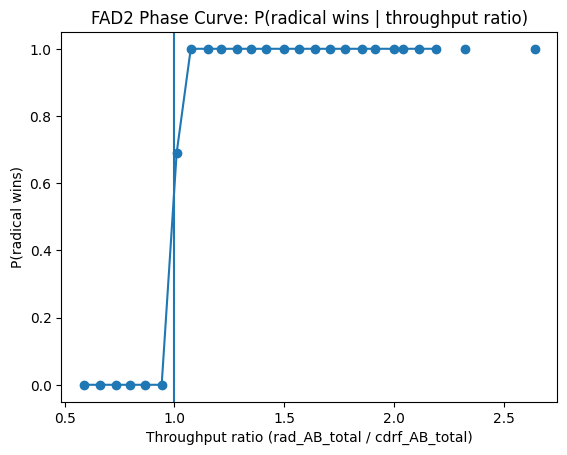

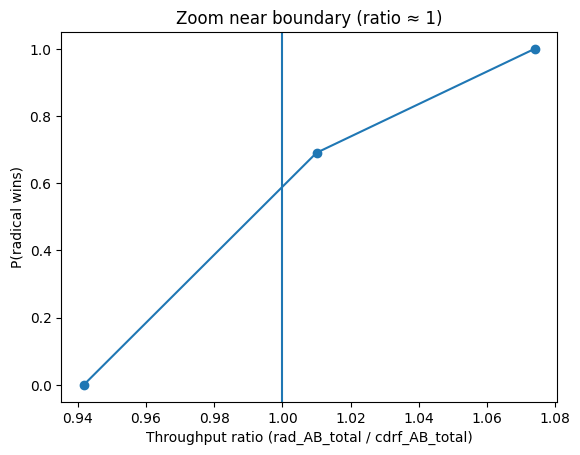

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load one of your ensembles (rates-only is the cleanest for the phase curve)
df = pd.read_csv("FAD2_rates_only_ensemble_full.csv")

# Use one environment (they're identical for win/loss in your outputs)
df = df[df["env"] == "equator_exposed"].copy()

# Define the control variable and outcome
df["throughput_ratio"] = df["rad_AB_total"] / df["cdrf_AB_total"]
df["rad_win"] = (df["rad_over_cdrf_AB"] > 1.0).astype(int)

# Bin throughput_ratio and compute P(radical wins | bin)
n_bins = 30
bins = np.linspace(df["throughput_ratio"].min(), df["throughput_ratio"].max(), n_bins + 1)
df["bin"] = pd.cut(df["throughput_ratio"], bins=bins, include_lowest=True)

phase = df.groupby("bin").agg(
    ratio_mid=("throughput_ratio", "mean"),
    p_rad_win=("rad_win", "mean"),
    n=("rad_win", "size")
).reset_index()

print("Phase curve table (first 12 bins):")
print(phase[["ratio_mid", "p_rad_win", "n"]].head(12).to_string(index=False))

# Plot: single figure, no explicit colors
plt.figure()
plt.plot(phase["ratio_mid"], phase["p_rad_win"], marker="o")
plt.axvline(1.0)
plt.xlabel("Throughput ratio (rad_AB_total / cdrf_AB_total)")
plt.ylabel("P(radical wins)")
plt.title("FAD2 Phase Curve: P(radical wins | throughput ratio)")
plt.ylim(-0.05, 1.05)
plt.show()

# Optional: zoom near the boundary for clarity
zoom = phase[(phase["ratio_mid"] > 0.9) & (phase["ratio_mid"] < 1.1)].copy()
if len(zoom) > 0:
    plt.figure()
    plt.plot(zoom["ratio_mid"], zoom["p_rad_win"], marker="o")
    plt.axvline(1.0)
    plt.xlabel("Throughput ratio (rad_AB_total / cdrf_AB_total)")
    plt.ylabel("P(radical wins)")
    plt.title("Zoom near boundary (ratio ≈ 1)")
    plt.ylim(-0.05, 1.05)
    plt.show()

In [ ]:
import json
import hashlib
from pathlib import Path
from collections import Counter

# ============================================================
# FAD2 GUARDRAILS + RUN MANIFEST
# Drop-in cell to prevent "ghost" wet-only results
# Assumes you already have:
#   - FAD1_EDGES (list of edges)
#   - ENVIRONMENTS (dict)
#   - GATE_SUMS (dict precomputed from ENVIRONMENTS)
#   - enumerate_paths(edges, start, goal, max_len)
#   - score_graph(edges, env_name)
# ============================================================

def _edge_sig(edges):
    t = sorted([(u,v,gt,round(float(k),12),note) for (u,v,gt,k,note) in edges])
    s = json.dumps(t).encode("utf-8")
    return hashlib.sha256(s).hexdigest()

def _count_families(paths):
    fam = Counter()
    for p in paths:
        nodes = set(p)
        if ("RFT" in nodes) or ("RFsq" in nodes):
            fam["radical_paths"] += 1
        elif "CDRF" in nodes:
            fam["cdrf_paths"] += 1
        else:
            fam["wet_only_paths"] += 1
    fam["total_paths"] = len(paths)
    return fam

def _gate_sanity(gate_sums):
    # Ensure UV and wet integrals are nonzero where expected
    return {
        "wet_A": float(gate_sums["wet_A"]),
        "wet_B": float(gate_sums["wet_B"]),
        "uv_A": float(gate_sums["uv_A"]),
        "uv_B": float(gate_sums["uv_B"]),
        "uv_total": float(gate_sums["uv_A"] + gate_sums["uv_B"]),
        "wet_total": float(gate_sums["wet_A"] + gate_sums["wet_B"]),
    }

def fad_run_manifest(run_name,
                     edges,
                     max_len=14,
                     start="Start",
                     goal="FAD",
                     extra_meta=None):
    # Enumerate once and record route structure
    paths, edge_meta = enumerate_paths(edges, start=start, goal=goal, max_len=max_len)
    fam_counts = _count_families(paths)

    # Gate sanity per environment
    gates = {env: _gate_sanity(GATE_SUMS[env]) for env in ENVIRONMENTS}

    # Quick AOI control scores per env
    scores = {}
    for env in ENVIRONMENTS:
        r = score_graph(edges, env)
        if r is None:
            scores[env] = None
        else:
            scores[env] = {
                "rad_over_cdrf_AB": float(r["rad_over_cdrf_AB"]),
                "rad_AB_total": float(r["rad_AB_total"]),
                "cdrf_AB_total": float(r["cdrf_AB_total"]),
                "wet_AB_total": float(r["wet_AB_total"]),
                "rad_DeltaP": float(r["rad_DeltaP"]),
                "cdrf_DeltaP": float(r["cdrf_DeltaP"]),
                "wet_DeltaP": float(r["wet_DeltaP"]),
            }

    manifest = {
        "run_name": str(run_name),
        "edge_sig_sha256": _edge_sig(edges),
        "edge_count": len(edges),
        "max_len": int(max_len),
        "start": str(start),
        "goal": str(goal),
        "route_family_counts": dict(fam_counts),
        "gate_integrals": gates,
        "control_scores": scores,
    }
    if extra_meta:
        manifest["extra_meta"] = extra_meta

    return manifest

def fad_guardrails(manifest):
    # --- Gate sanity: UV must exist (unless you intentionally set it to zero) ---
    for env, g in manifest["gate_integrals"].items():
        if g["uv_total"] <= 0:
            raise RuntimeError(f"[GUARDRAIL FAIL] UV integral is zero in env={env}. UV gating is effectively off.")

    # --- Route enumeration sanity ---
    counts = manifest["route_family_counts"]
    if counts.get("total_paths", 0) <= 0:
        raise RuntimeError("[GUARDRAIL FAIL] No Start->FAD paths were enumerated. Check graph connectivity or max_len.")

    # If you expect radical/CDRF routes to exist, enforce they are present:
    if counts.get("radical_paths", 0) == 0:
        raise RuntimeError("[GUARDRAIL FAIL] Zero radical paths enumerated. Likely max_len too short or node naming mismatch (RFT/RFsq).")
    if counts.get("cdrf_paths", 0) == 0:
        raise RuntimeError("[GUARDRAIL FAIL] Zero CDRF paths enumerated. Likely max_len too short or node naming mismatch (CDRF).")

    # --- Control sanity: rad_over_cdrf_AB should be > 1 for curated FAD1 ---
    # (If you are running a non-curated graph, skip this check by setting extra_meta={"skip_control_check": True})
    if not (manifest.get("extra_meta", {}) or {}).get("skip_control_check", False):
        for env, s in manifest["control_scores"].items():
            if s is None:
                raise RuntimeError(f"[GUARDRAIL FAIL] No control score computed in env={env}.")
            if not (s["rad_over_cdrf_AB"] > 1.0):
                raise RuntimeError(f"[GUARDRAIL FAIL] Control rad_over_cdrf_AB <= 1 in env={env}. This suggests drift in scoring, gates, or topology.")

    return True

# ------------------------------------------------------------
# RUN THIS FOR YOUR CURRENT CURATED FAD1 GRAPH
# ------------------------------------------------------------
RUN_NAME = "FAD2_guardrails_curated_control"

manifest = fad_run_manifest(
    run_name=RUN_NAME,
    edges=FAD1_EDGES,
    max_len=14,
    start="Start",
    goal="FAD",
    extra_meta={
        "note": "Curated FAD1 graph. Guardrails enforce UV present + radical/CDRF routes exist + rad_over_cdrf_AB > 1.",
    }
)

fad_guardrails(manifest)

# Save manifest JSON (timestamp-free, deterministic name)
out = Path(".") / f"{RUN_NAME}_manifest.json"
out.write_text(json.dumps(manifest, indent=2))
print("GUARDRAILS PASSED. Manifest saved to:", out.name)

# Pretty print key diagnostics
print("\n--- ROUTE COUNTS ---")
print(manifest["route_family_counts"])
print("\n--- EDGE SIG ---")
print(manifest["edge_sig_sha256"][:16], "(sha256 prefix)")
print("\n--- GATE INTEGRALS (uv_total, wet_total) ---")
for env, g in manifest["gate_integrals"].items():
    print(env, "uv_total=", round(g["uv_total"], 6), "wet_total=", round(g["wet_total"], 6))
print("\n--- CONTROL rad_over_cdrf_AB ---")
for env, s in manifest["control_scores"].items():
    print(env, "rad_over_cdrf_AB=", s["rad_over_cdrf_AB"])

GUARDRAILS PASSED. Manifest saved to: FAD2_guardrails_curated_control_manifest.json

--- ROUTE COUNTS ---
{'wet_only_paths': 1, 'cdrf_paths': 1, 'radical_paths': 1, 'total_paths': 3}

--- EDGE SIG ---
677fbbbc75952ff5 (sha256 prefix)

--- GATE INTEGRALS (uv_total, wet_total) ---
equator_exposed uv_total= 365.0 wet_total= 365.0
refuge uv_total= 109.5 wet_total= 365.0
wet_season_refuge uv_total= 109.5 wet_total= 365.0

--- CONTROL rad_over_cdrf_AB ---
equator_exposed rad_over_cdrf_AB= 1.2
refuge rad_over_cdrf_AB= 1.1999999999999997
wet_season_refuge rad_over_cdrf_AB= 1.1999999999999997


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


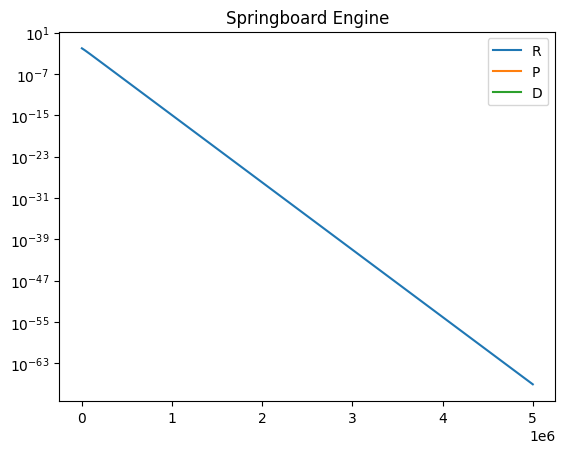

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_engine(
    T=5000, dt=0.001,
    S_F=0.02,
    kF_damage=0.05,
    kR_damage=0.03,
    kP_damage=0.02,
    kD_damage=0.01,
    alpha_FR=1.0,
    alpha_RP=1.0,
    alpha_PD=1.0,
    shade_strength=0.5,
    beta_bind=0.5,
    K=10.0,
    refuge=1.0
):
    F_free = 0.1
    F_bound = 0.0
    R = 0.01
    P = 0.0
    D = 0.0

    F_hist, R_hist, P_hist, D_hist = [], [], [], []

    for _ in range(int(T*dt**-1)):

        # Shading reduces damage
        shade = 1.0 - shade_strength * P
        shade = max(0.0, shade)

        kF = kF_damage * refuge * shade
        kR = kR_damage * refuge * shade
        kP = kP_damage * refuge * shade
        kD = kD_damage * refuge * shade

        # Flavin production & loss
        dF = S_F - kF * F_free
        F_free += dF * dt
        F_free = max(0.0, F_free)

        # Service limitation
        demand = beta_bind * (R + P + D)
        F_bound = min(F_free, demand)

        # R growth (springboard)
        dR = alpha_FR * F_bound * R * (1 - R/K) - kR * R
        R += dR * dt
        R = max(0.0, R)

        # P growth
        dP = alpha_RP * R * P * (1 - P/K) - kP * P
        P += dP * dt
        P = max(0.0, P)

        # D growth
        dD = alpha_PD * P * D * (1 - D/K) - kD * D
        D += dD * dt
        D = max(0.0, D)

        F_hist.append(F_free)
        R_hist.append(R)
        P_hist.append(P)
        D_hist.append(D)

    return np.array(F_hist), np.array(R_hist), np.array(P_hist), np.array(D_hist)

F, R, P, D = simulate_engine()

plt.figure()
plt.plot(R, label="R")
plt.plot(P, label="P")
plt.plot(D, label="D")
plt.yscale("log")
plt.legend()
plt.title("Springboard Engine")
plt.show()

scenario  thr  t_R  t_P  t_D  final_F  final_R  final_P  final_D
baseline 0.01  NaN  NaN  NaN 0.909266 0.000050 0.000007 0.000001
baseline 0.10  NaN  NaN  NaN 0.909266 0.000050 0.000007 0.000001
baseline 1.00  NaN  NaN  NaN 0.909266 0.000050 0.000007 0.000001
  F_to_R 0.01  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
  F_to_R 0.10  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
  F_to_R 1.00  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
   F_R_P 0.01  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
   F_R_P 0.10  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
   F_R_P 1.00  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
 F_R_P_D 0.01  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
 F_R_P_D 0.10  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001
 F_R_P_D 1.00  NaN  NaN  NaN 0.909268 0.000051 0.000007 0.000001


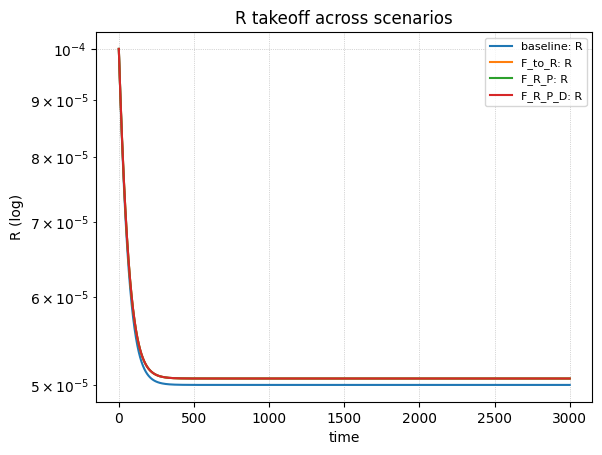

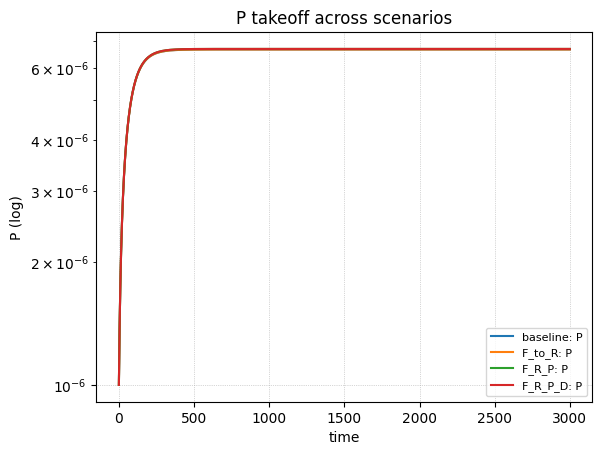

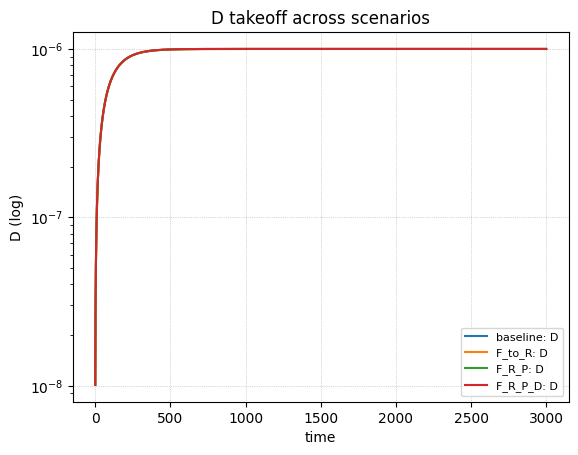

Saved: engine_springboard_summary.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# PRE-RNA ENGINE: F -> R -> P -> D springboard harness
# ============================================================

def run_engine(
    T=3000.0, dt=0.01,
    # Flavin production & loss
    S_F=0.02,                 # AOI-selected net formation rate (aggregate)
    kF_damage=0.02,           # UV/oxidative loss on free flavin
    # Basal trickles (set to 0.0 if you want strict dependency only)
    sR=1e-6, sP=1e-7, sD=1e-8,
    # Damage rates (scaled by UV and reduced by shading)
    kR_damage=0.02, kP_damage=0.015, kD_damage=0.01,
    # Springboard couplings (set to 0 to "turn off" a coupling)
    alpha_FR=1.5,             # F-bound catalysis into R growth
    alpha_RP=1.0,             # R catalysis into P growth
    alpha_PD=0.8,             # P shelter/templating into D growth
    # Saturations / carrying caps
    K_F=10.0, K_R=10.0, K_P=10.0, K_D=10.0,
    # Flavin service limitation
    bind_strength=0.6,         # how strongly demand binds F_free into F_bound
    bind_release=0.2,          # release back from bound pool
    # Shading feedback: P reduces UV effective damage
    shade_strength=0.4,        # 0=no shading; higher = more protection
    # UV environment
    uv_level=1.0,              # overall UV severity multiplier
    refuge=1.0,                # <1 means sheltered (reduces UV severity)
    # Seeds
    F0=0.1, R0=1e-4, P0=1e-6, D0=1e-8
):
    n = int(T / dt)
    t = np.arange(n) * dt

    F_free = float(F0)
    F_bound = 0.0
    R = float(R0)
    P = float(P0)
    D = float(D0)

    Fh = np.zeros(n)
    Rh = np.zeros(n)
    Ph = np.zeros(n)
    Dh = np.zeros(n)

    for i in range(n):
        # Shading reduces effective damage. Clamp to nonnegative.
        shade = max(0.0, 1.0 - shade_strength * P)

        # Effective UV multiplier (refuge reduces UV)
        uv_eff = uv_level * refuge

        # Effective damage rates
        kF = kF_damage * uv_eff * shade
        kR = kR_damage * uv_eff * shade
        kP = kP_damage * uv_eff * shade
        kD = kD_damage * uv_eff * shade

        # ---- Flavin dynamics ----
        # F_free: produced and damaged; saturate softly by K_F
        dF_free = S_F * (1.0 - F_free / K_F) - kF * F_free

        # Binding demand for flavin service (catalysis/sequestration)
        demand = bind_strength * (R + P + D)
        # Bind from free -> bound, and release bound -> free
        bind_flow = min(F_free, demand) * dt
        release_flow = bind_release * F_bound * dt

        # Update free and bound with production/loss
        F_free = max(0.0, F_free + dF_free * dt)
        F_free = max(0.0, F_free - bind_flow + release_flow)
        F_bound = max(0.0, F_bound + bind_flow - release_flow)

        # ---- R dynamics ----
        # Basal trickle + catalysed growth; logistic cap; damage sink
        growth_R = sR + alpha_FR * F_bound * R * (1.0 - R / K_R)
        dR = growth_R - kR * R
        R = max(0.0, R + dR * dt)

        # ---- P dynamics ----
        growth_P = sP + alpha_RP * R * P * (1.0 - P / K_P)
        dP = growth_P - kP * P
        P = max(0.0, P + dP * dt)

        # ---- D dynamics ----
        growth_D = sD + alpha_PD * P * D * (1.0 - D / K_D)
        dD = growth_D - kD * D
        D = max(0.0, D + dD * dt)

        Fh[i] = F_free + F_bound
        Rh[i] = R
        Ph[i] = P
        Dh[i] = D

    return t, Fh, Rh, Ph, Dh


def time_to_threshold(t, x, thresh):
    idx = np.where(x >= thresh)[0]
    return float(t[idx[0]]) if len(idx) else np.nan


def run_scenarios_and_report(
    uv_level=1.0, refuge=1.0, shade_strength=0.4,
    thresholds=(0.01, 0.1, 1.0),
    T=3000.0, dt=0.01
):
    scenarios = [
        ("baseline", dict(alpha_FR=0.0, alpha_RP=0.0, alpha_PD=0.0)),
        ("F_to_R",   dict(alpha_FR=1.5, alpha_RP=0.0, alpha_PD=0.0)),
        ("F_R_P",    dict(alpha_FR=1.5, alpha_RP=1.0, alpha_PD=0.0)),
        ("F_R_P_D",  dict(alpha_FR=1.5, alpha_RP=1.0, alpha_PD=0.8)),
    ]

    runs = {}
    rows = []

    for name, overrides in scenarios:
        t, F, R, P, D = run_engine(
            T=T, dt=dt,
            uv_level=uv_level, refuge=refuge,
            shade_strength=shade_strength,
            **overrides
        )
        runs[name] = (t, F, R, P, D)

        for thr in thresholds:
            rows.append({
                "scenario": name,
                "thr": thr,
                "t_R": time_to_threshold(t, R, thr),
                "t_P": time_to_threshold(t, P, thr),
                "t_D": time_to_threshold(t, D, thr),
                "final_F": float(F[-1]),
                "final_R": float(R[-1]),
                "final_P": float(P[-1]),
                "final_D": float(D[-1]),
            })

    df = pd.DataFrame(rows)
    return runs, df


# =========================
# RUN IT
# =========================
runs, summary = run_scenarios_and_report(
    uv_level=1.0,
    refuge=1.0,
    shade_strength=0.4,
    thresholds=(0.01, 0.1, 1.0),
    T=3000.0,
    dt=0.01
)

print(summary.to_string(index=False))

# =========================
# PLOTS
# =========================
# Plot R/P/D for each scenario (single plot, no explicit colors)
plt.figure()
for name, (t, F, R, P, D) in runs.items():
    plt.plot(t, R, label=f"{name}: R")
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("R (log)")
plt.title("R takeoff across scenarios")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(fontsize=8)
plt.show()

plt.figure()
for name, (t, F, R, P, D) in runs.items():
    plt.plot(t, P, label=f"{name}: P")
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("P (log)")
plt.title("P takeoff across scenarios")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(fontsize=8)
plt.show()

plt.figure()
for name, (t, F, R, P, D) in runs.items():
    plt.plot(t, D, label=f"{name}: D")
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("D (log)")
plt.title("D takeoff across scenarios")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(fontsize=8)
plt.show()

# Save the summary table if you want
summary.to_csv("engine_springboard_summary.csv", index=False)
print("Saved: engine_springboard_summary.csv")

scenario  thr   t_R   t_P   t_D  final_F   final_R      final_P      final_D
baseline 0.01   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
baseline 0.10   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
baseline 1.00   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
  F_to_R 0.01   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
  F_to_R 0.10   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
  F_to_R 1.00   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
   F_R_P 0.01 90.84 76.18   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
   F_R_P 0.10 93.38 93.21   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
   F_R_P 1.00 94.43 94.79   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
 F_R_P_D 0.01 30.26 28.68 16.61 9.975127 10.000000 1.000000e+01 1.000000e+01
 F_R_P_D 0.10 32.34 32.38 31.81 9.975127 10.000000 1.000000e+01 1.000000e+01
 F_R_P_D 1.00 34.32 34.48 34.76 9.975127 10.000000 1.000000e+01 1.000000e+01

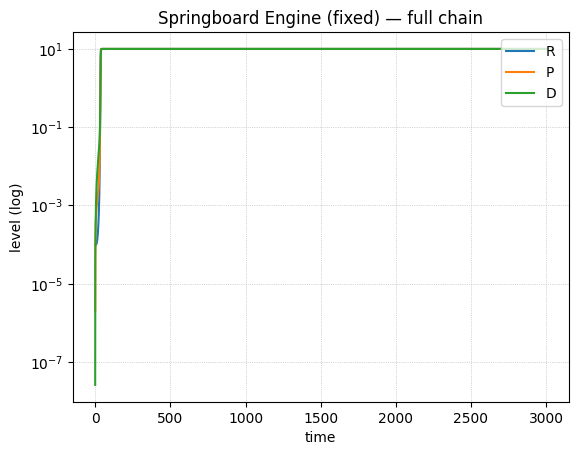

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_engine(
    T=3000.0, dt=0.01,

    # Flavin supply
    S_F=0.02,
    kF_damage=0.01,

    # Basal trickles (can be 0, but then you need nonzero seeds)
    sR=1e-6, sP=1e-8, sD=1e-10,

    # Damage (scaled by UV and reduced by shading)
    kR_damage=0.02, kP_damage=0.015, kD_damage=0.01,

    # Springboard couplings
    alpha_FR=2.0,      # F helps R
    alpha_RP=1.0,      # R helps P
    alpha_PD=0.8,      # P helps D

    # Carrying caps
    K_F=10.0, K_R=10.0, K_P=10.0, K_D=10.0,

    # Service allocation: how much F can be bound per unit (R+P+D)
    bind_strength=5.0,

    # Shading: P reduces UV damage
    shade_strength=0.6,

    # Environment severity
    uv_level=1.0,
    refuge=1.0,

    # Seeds
    F0=0.1, R0=1e-4, P0=1e-6, D0=1e-8
):
    n = int(T / dt)
    t = np.arange(n) * dt

    F_tot = float(F0)
    R = float(R0)
    P = float(P0)
    D = float(D0)

    Fh = np.zeros(n)
    Rh = np.zeros(n)
    Ph = np.zeros(n)
    Dh = np.zeros(n)

    for i in range(n):
        # shading reduces effective UV damage
        shade = max(0.0, 1.0 - shade_strength * P)
        uv_eff = uv_level * refuge

        kF = kF_damage * uv_eff * shade
        kR = kR_damage * uv_eff * shade
        kP = kP_damage * uv_eff * shade
        kD = kD_damage * uv_eff * shade

        # Flavin total dynamics (simple supply with cap + loss)
        dF = S_F * (1.0 - F_tot / K_F) - kF * F_tot
        F_tot = max(0.0, F_tot + dF * dt)

        # Instantaneous service allocation (THIS is the key fix)
        demand = bind_strength * (R + P + D)
        F_bound = min(F_tot, demand)
        F_free = F_tot - F_bound

        # R dynamics: basal + F-assisted growth, logistic, minus damage
        growth_R = sR + alpha_FR * F_bound * R * (1.0 - R / K_R)
        R = max(0.0, R + (growth_R - kR * R) * dt)

        # P dynamics: basal + R-driven assembly (not P*R), logistic, minus damage
        growth_P = sP + alpha_RP * R * (1.0 - P / K_P)
        P = max(0.0, P + (growth_P - kP * P) * dt)

        # D dynamics: basal + P-driven stabilisation/replication (not D*P), logistic, minus damage
        growth_D = sD + alpha_PD * P * (1.0 - D / K_D)
        D = max(0.0, D + (growth_D - kD * D) * dt)

        Fh[i] = F_tot
        Rh[i] = R
        Ph[i] = P
        Dh[i] = D

    return t, Fh, Rh, Ph, Dh

def time_to_threshold(t, x, thr):
    idx = np.where(x >= thr)[0]
    return float(t[idx[0]]) if len(idx) else np.nan

def run_scenarios_and_report(
    uv_level=1.0, refuge=1.0, shade_strength=0.6,
    thresholds=(0.01, 0.1, 1.0),
    T=3000.0, dt=0.01
):
    scenarios = [
        ("baseline", dict(alpha_FR=0.0, alpha_RP=0.0, alpha_PD=0.0)),
        ("F_to_R",   dict(alpha_FR=2.0, alpha_RP=0.0, alpha_PD=0.0)),
        ("F_R_P",    dict(alpha_FR=2.0, alpha_RP=1.0, alpha_PD=0.0)),
        ("F_R_P_D",  dict(alpha_FR=2.0, alpha_RP=1.0, alpha_PD=0.8)),
    ]

    runs = {}
    rows = []
    for name, overrides in scenarios:
        t, F, R, P, D = run_engine(
            T=T, dt=dt,
            uv_level=uv_level, refuge=refuge,
            shade_strength=shade_strength,
            **overrides
        )
        runs[name] = (t, F, R, P, D)

        for thr in thresholds:
            rows.append({
                "scenario": name,
                "thr": thr,
                "t_R": time_to_threshold(t, R, thr),
                "t_P": time_to_threshold(t, P, thr),
                "t_D": time_to_threshold(t, D, thr),
                "final_F": float(F[-1]),
                "final_R": float(R[-1]),
                "final_P": float(P[-1]),
                "final_D": float(D[-1]),
            })

    return runs, pd.DataFrame(rows)

# Run
runs, summary = run_scenarios_and_report(
    uv_level=1.0, refuge=1.0, shade_strength=0.6,
    thresholds=(0.01, 0.1, 1.0),
    T=3000.0, dt=0.01
)

print(summary.to_string(index=False))
summary.to_csv("engine_springboard_summary_fixed.csv", index=False)
print("Saved: engine_springboard_summary_fixed.csv")

# Quick plot: R,P,D for the full chain
t, F, R, P, D = runs["F_R_P_D"]
plt.figure()
plt.plot(t[::50], R[::50], label="R")
plt.plot(t[::50], P[::50], label="P")
plt.plot(t[::50], D[::50], label="D")
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("level (log)")
plt.title("Springboard Engine (fixed) — full chain")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(loc="upper right")
plt.show()

Loaded: engine_springboard_summary_fixed.csv
scenario  thr   t_R   t_P   t_D  final_F   final_R      final_P      final_D
baseline 0.01   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
baseline 0.10   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
baseline 1.00   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
  F_to_R 0.01   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
  F_to_R 0.10   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
  F_to_R 1.00   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
   F_R_P 0.01 90.84 76.18   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
   F_R_P 0.10 93.38 93.21   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
   F_R_P 1.00 94.43 94.79   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
 F_R_P_D 0.01 30.26 28.68 16.61 9.975127 10.000000 1.000000e+01 1.000000e+01
 F_R_P_D 0.10 32.34 32.38 31.81 9.975127 10.000000 1.000000e+01 1.000000e+01
 F_R_P_D 1.00 34.32 34.48 34.76

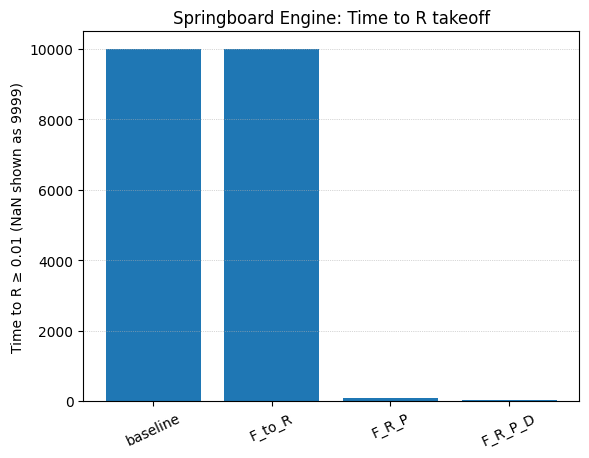

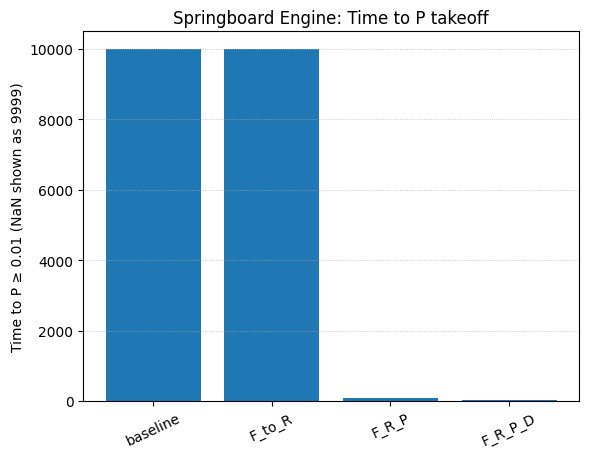

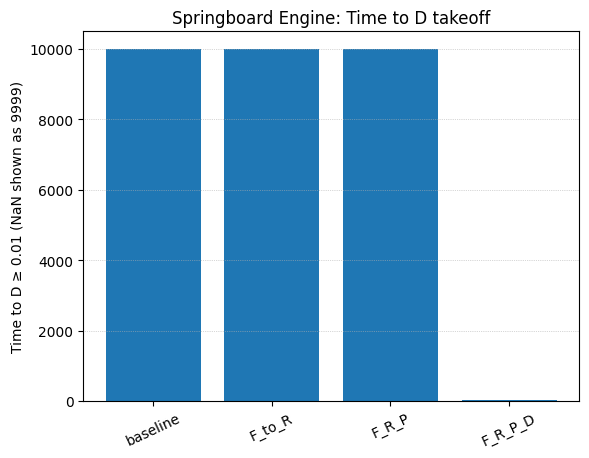

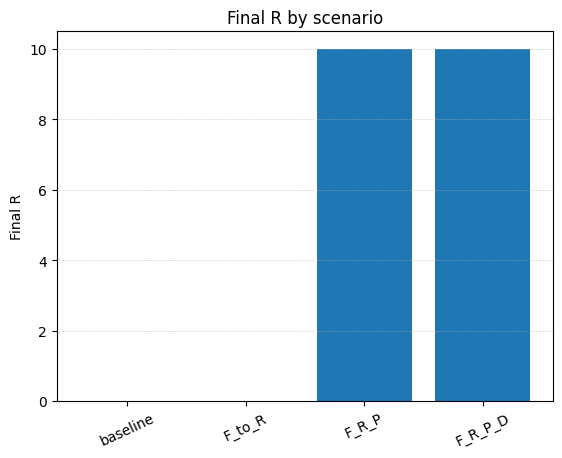

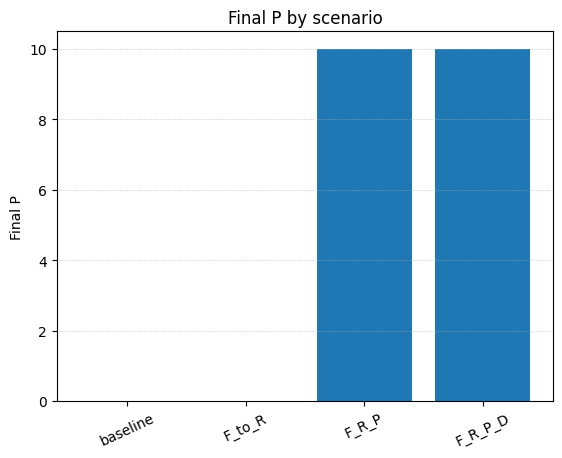

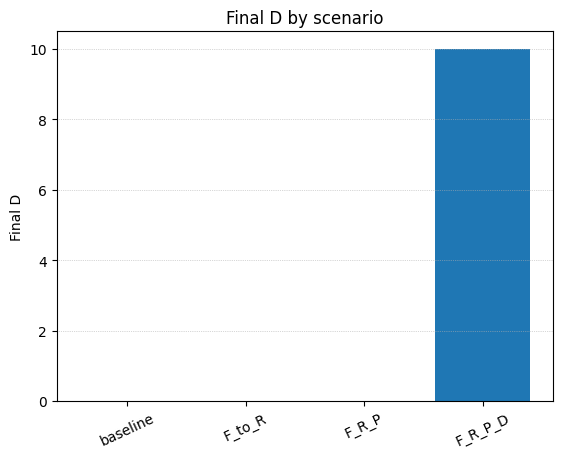


Paper-friendly table (thr=0.01):
scenario   t_R   t_P   t_D  final_F   final_R      final_P      final_D
baseline   NaN   NaN   NaN 1.666667  0.000050 6.666669e-07 1.000000e-08
  F_to_R   NaN   NaN   NaN 1.666667  0.000051 6.666669e-07 1.000000e-08
   F_R_P 90.84 76.18   NaN 9.973547 10.000000 1.000000e+01 3.005800e-07
 F_R_P_D 30.26 28.68 16.61 9.975127 10.000000 1.000000e+01 1.000000e+01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Load the CORRECT summary file
# ----------------------------
CSV = "engine_springboard_summary_fixed.csv"
df = pd.read_csv(CSV)

print("Loaded:", CSV)
print(df.head(12).to_string(index=False))

# ----------------------------
# Helper: NaNs -> big number for plotting, and mark as "no takeoff"
# ----------------------------
def nan_to_big(x, big=9999.0):
    return np.where(np.isfinite(x), x, big)

# ----------------------------
# 1) Times to threshold (thr = 0.01)
# ----------------------------
thr = 0.01
sub = df[df["thr"] == thr].copy()

# Sort in a sensible narrative order
order = ["baseline", "F_to_R", "F_R_P", "F_R_P_D"]
sub["scenario"] = pd.Categorical(sub["scenario"], categories=order, ordered=True)
sub = sub.sort_values("scenario")

# Plot time to R
plt.figure()
plt.bar(sub["scenario"], nan_to_big(sub["t_R"]))
plt.ylabel(f"Time to R ≥ {thr} (NaN shown as 9999)")
plt.title("Springboard Engine: Time to R takeoff")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

# Plot time to P
plt.figure()
plt.bar(sub["scenario"], nan_to_big(sub["t_P"]))
plt.ylabel(f"Time to P ≥ {thr} (NaN shown as 9999)")
plt.title("Springboard Engine: Time to P takeoff")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

# Plot time to D
plt.figure()
plt.bar(sub["scenario"], nan_to_big(sub["t_D"]))
plt.ylabel(f"Time to D ≥ {thr} (NaN shown as 9999)")
plt.title("Springboard Engine: Time to D takeoff")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

# ----------------------------
# 2) Final levels (one row per scenario)
# ----------------------------
finals = df.drop_duplicates(subset=["scenario"]).copy()
finals["scenario"] = pd.Categorical(finals["scenario"], categories=order, ordered=True)
finals = finals.sort_values("scenario")

plt.figure()
plt.bar(finals["scenario"], finals["final_R"])
plt.ylabel("Final R")
plt.title("Final R by scenario")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

plt.figure()
plt.bar(finals["scenario"], finals["final_P"])
plt.ylabel("Final P")
plt.title("Final P by scenario")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

plt.figure()
plt.bar(finals["scenario"], finals["final_D"])
plt.ylabel("Final D")
plt.title("Final D by scenario")
plt.xticks(rotation=25)
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

# ----------------------------
# 3) Optional: pretty table for the paper (thr=0.01 only)
# ----------------------------
paper = sub[["scenario", "t_R", "t_P", "t_D", "final_F", "final_R", "final_P", "final_D"]].copy()
print("\nPaper-friendly table (thr=0.01):")
print(paper.to_string(index=False))

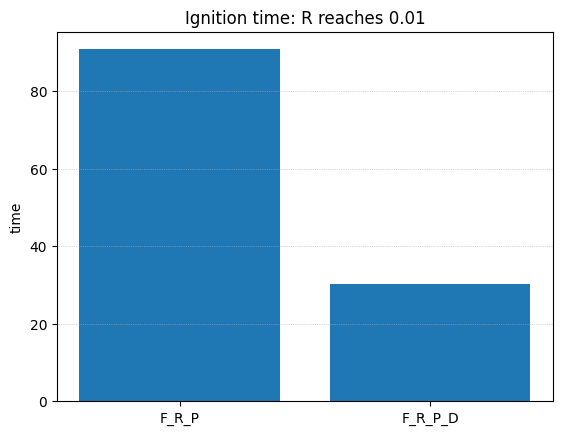

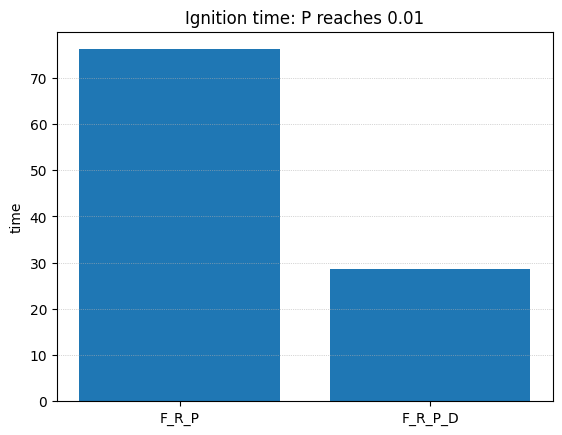

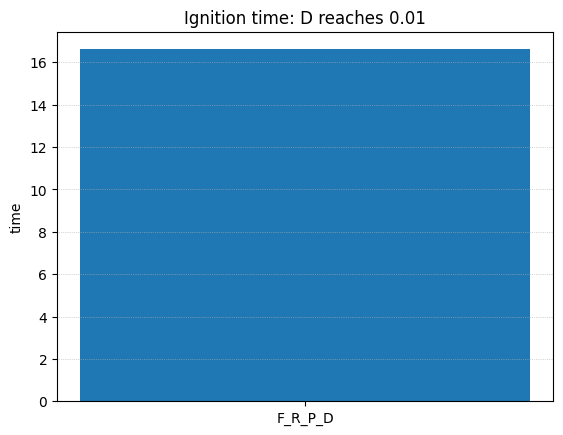

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("engine_springboard_summary_fixed.csv")

thr = 0.01
sub = df[df["thr"] == thr].copy()

order = ["baseline","F_to_R","F_R_P","F_R_P_D"]
sub["scenario"] = pd.Categorical(sub["scenario"], categories=order, ordered=True)
sub = sub.sort_values("scenario")

def plot_times(col, title, ylabel):
    s = sub[["scenario", col]].dropna()
    plt.figure()
    plt.bar(s["scenario"], s[col])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
    plt.show()

plot_times("t_R", "Ignition time: R reaches 0.01", "time")
plot_times("t_P", "Ignition time: P reaches 0.01", "time")
plot_times("t_D", "Ignition time: D reaches 0.01", "time")

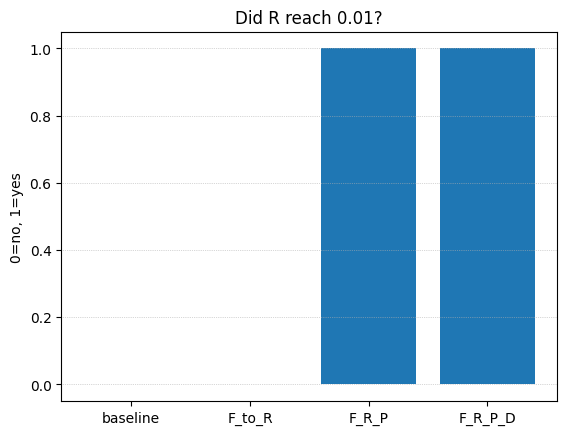

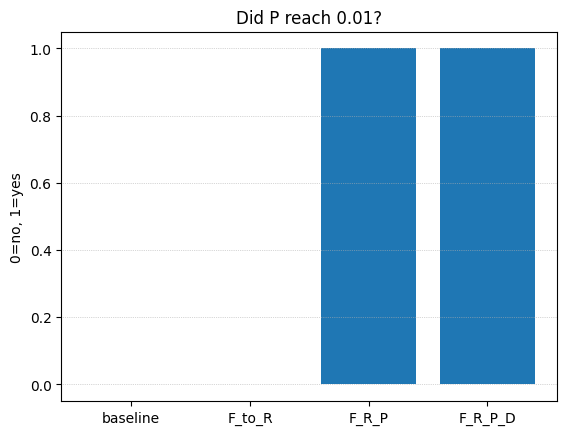

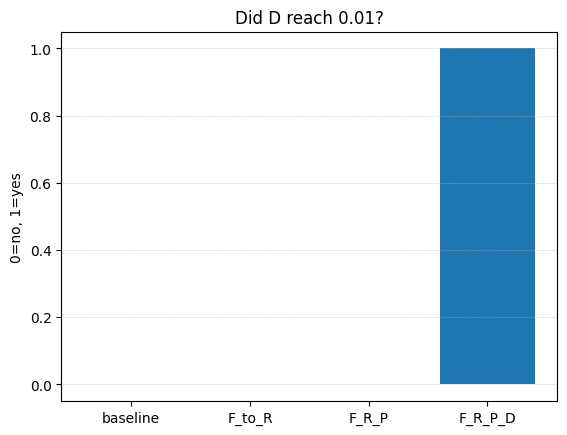

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("engine_springboard_summary_fixed.csv")
thr = 0.01
sub = df[df["thr"] == thr].copy()

order = ["baseline","F_to_R","F_R_P","F_R_P_D"]
sub["scenario"] = pd.Categorical(sub["scenario"], categories=order, ordered=True)
sub = sub.sort_values("scenario")

# 1 if reached threshold, 0 if not
sub["R_reached"] = np.isfinite(sub["t_R"]).astype(int)
sub["P_reached"] = np.isfinite(sub["t_P"]).astype(int)
sub["D_reached"] = np.isfinite(sub["t_D"]).astype(int)

plt.figure()
plt.bar(sub["scenario"], sub["R_reached"])
plt.ylim(-0.05, 1.05)
plt.title("Did R reach 0.01?")
plt.ylabel("0=no, 1=yes")
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

plt.figure()
plt.bar(sub["scenario"], sub["P_reached"])
plt.ylim(-0.05, 1.05)
plt.title("Did P reach 0.01?")
plt.ylabel("0=no, 1=yes")
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

plt.figure()
plt.bar(sub["scenario"], sub["D_reached"])
plt.ylim(-0.05, 1.05)
plt.title("Did D reach 0.01?")
plt.ylabel("0=no, 1=yes")
plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
plt.show()

Saved: PRDF_three_worlds_daily.csv


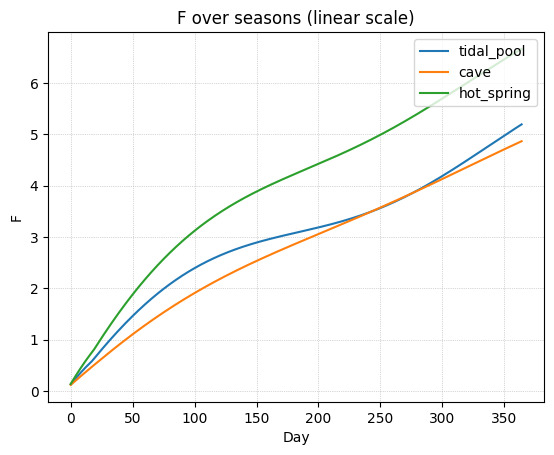

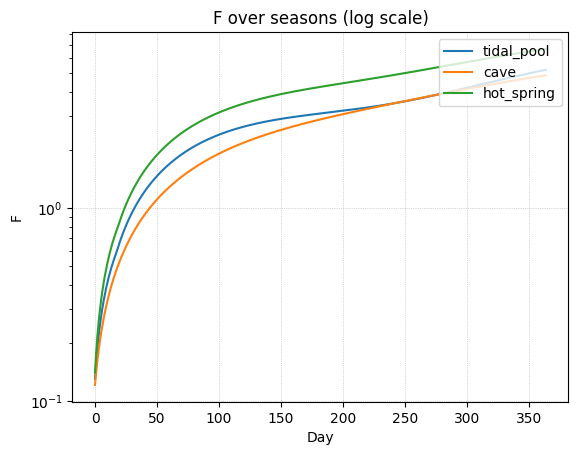

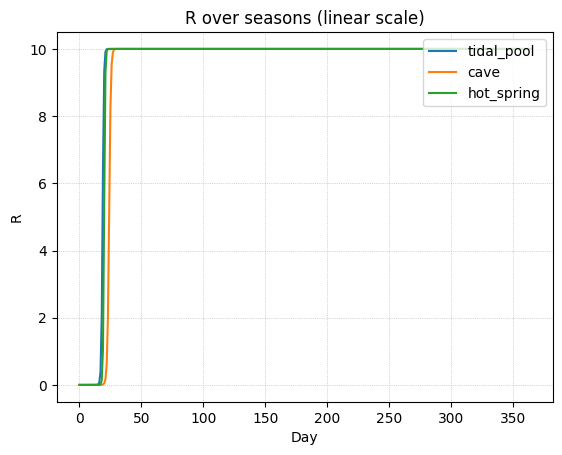

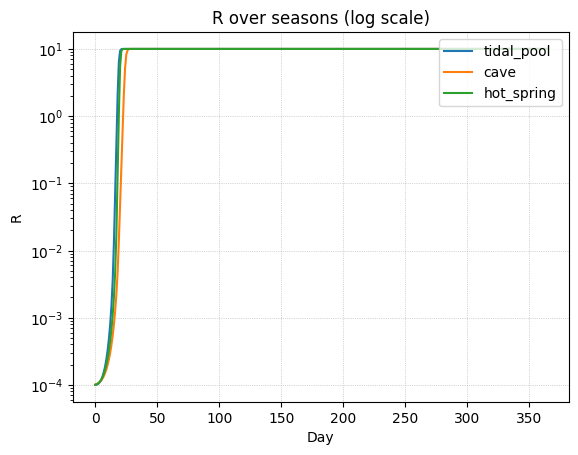

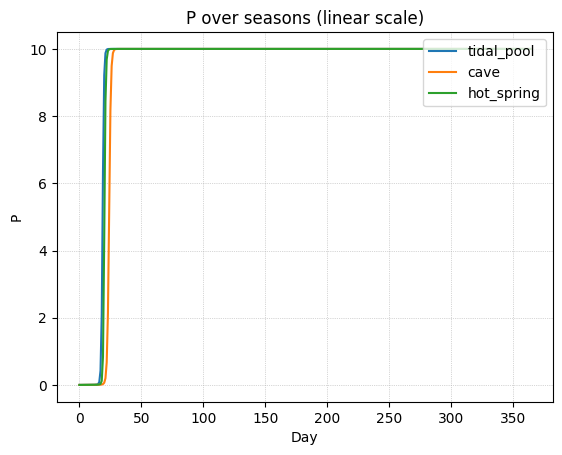

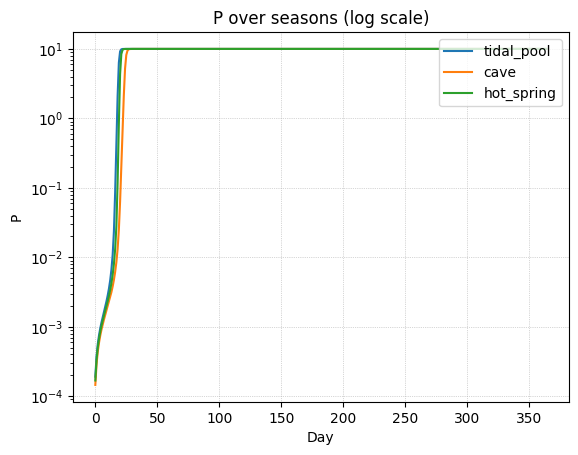

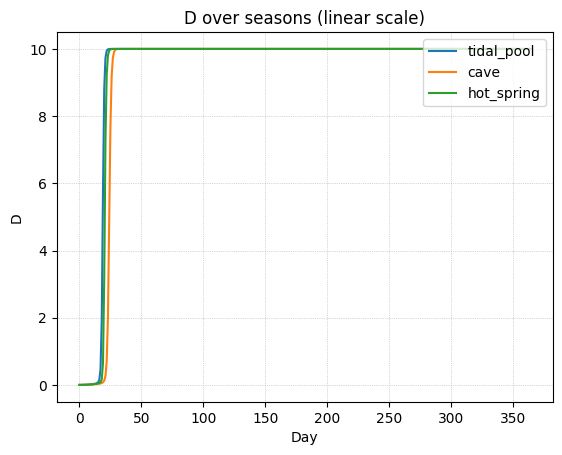

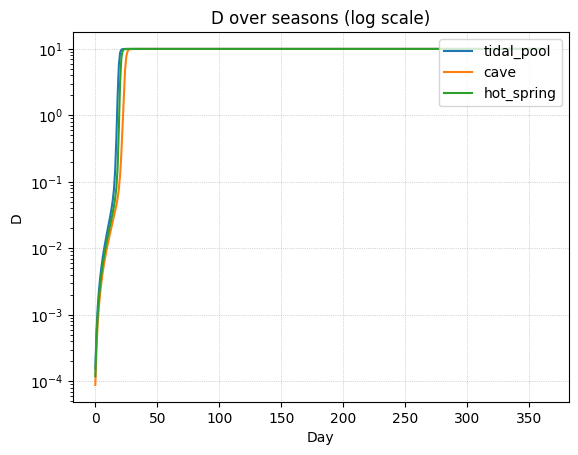

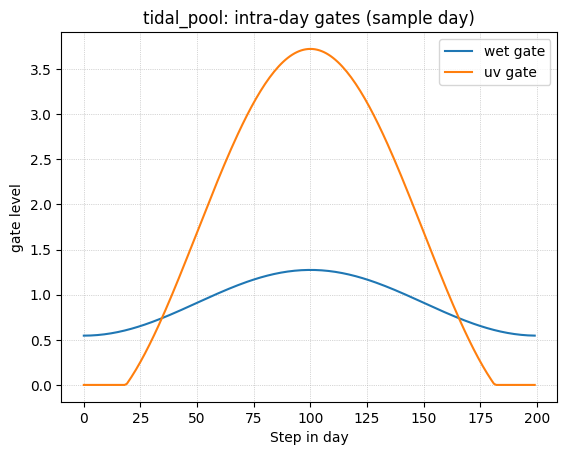

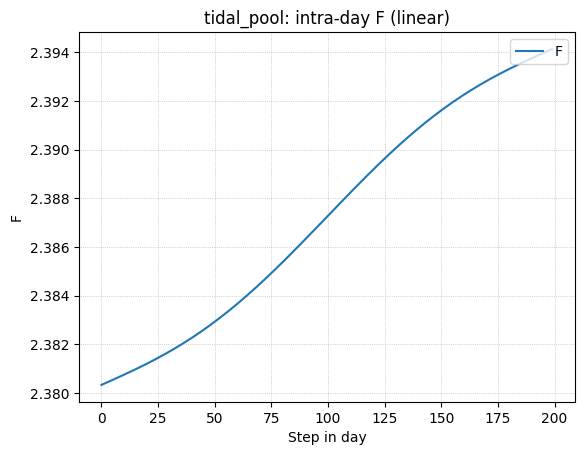

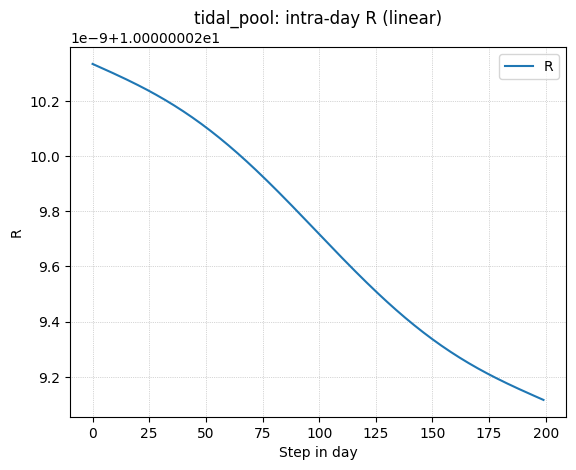

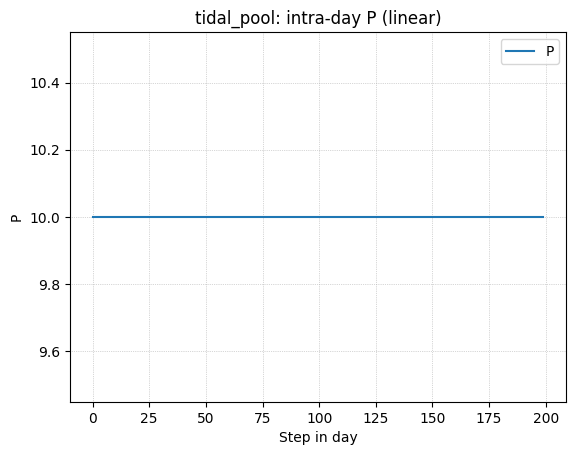

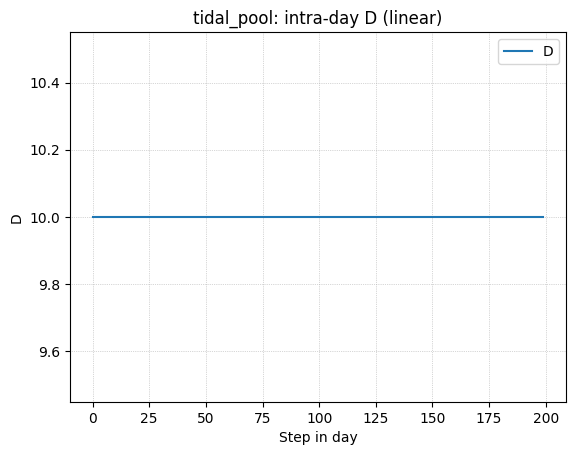

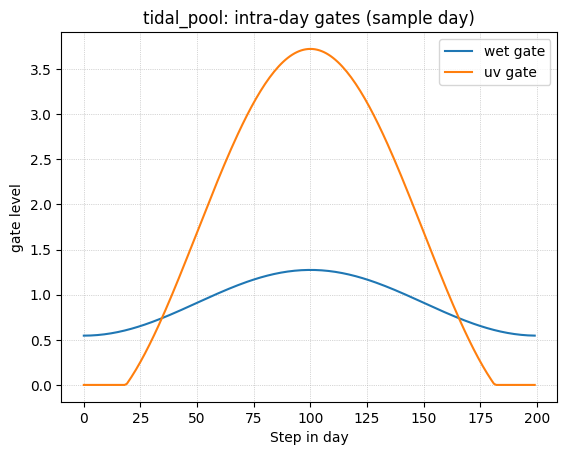

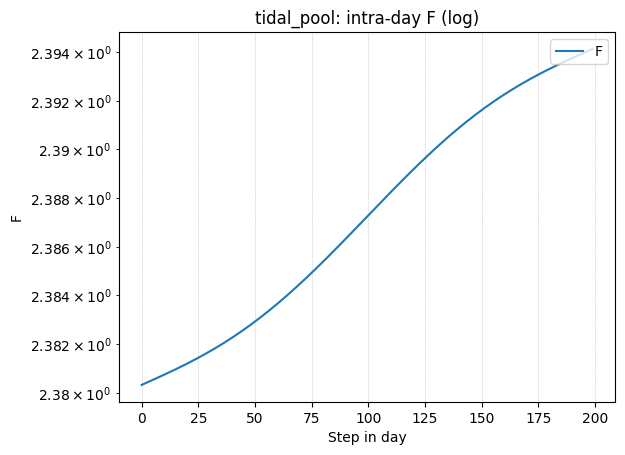

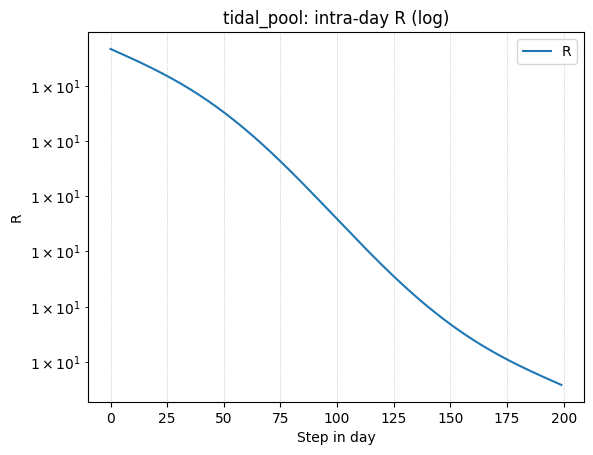

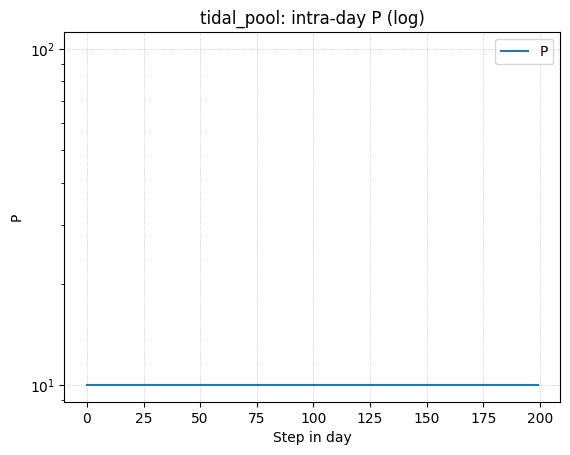

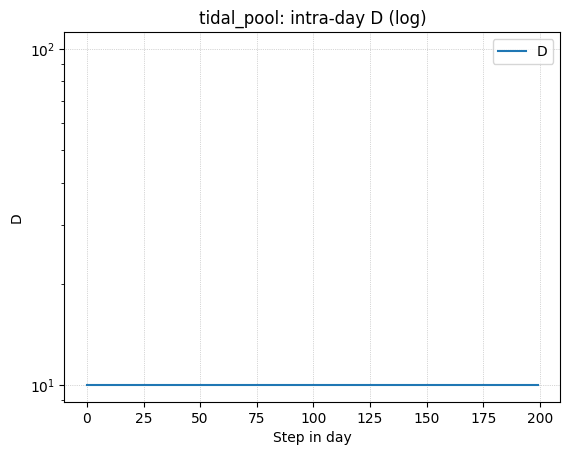

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Forcing: seasonal + diurnal
# ============================
def seasonal(day, period_days=365, amp=0.6, phase=0.0):
    return 1.0 + amp * np.sin(2.0 * np.pi * (day / period_days) + phase)

def diurnal(step, steps_per_day=200, amp=1.0, phase=-np.pi/2):
    raw = 1.0 + amp * np.sin(2.0 * np.pi * (step / steps_per_day) + phase)
    return max(0.0, raw)

def gates(day, step, steps_per_day,
          seasonal_uv_amp=0.6, diurnal_uv_amp=1.0,
          seasonal_wet_amp=0.3, diurnal_wet_amp=0.2,
          refuge=1.0):
    # UV = seasonal * diurnal * refuge
    uv = seasonal(day, amp=seasonal_uv_amp) * diurnal(step, steps_per_day, amp=diurnal_uv_amp) * refuge
    # wet = (shifted seasonal) * (mild diurnal), clipped >=0
    wet = seasonal(day, amp=seasonal_wet_amp, phase=np.pi/2) * diurnal(step, steps_per_day, amp=diurnal_wet_amp)
    return wet, uv

# ============================
# PRDF engine (minimal, dynamic)
# ============================
def simulate_world(
    world_name,
    days=365,
    steps_per_day=200,

    # World forcing
    seasonal_uv_amp=0.6,
    diurnal_uv_amp=1.0,
    seasonal_wet_amp=0.3,
    diurnal_wet_amp=0.2,
    refuge=1.0,

    # "Temperature" proxy: scales both formation and damage
    temp_kinetics=1.0,       # >1 speeds formation terms
    temp_damage=1.0,         # >1 increases decay terms

    # Couplings (springboards)
    alpha_FR=2.0,
    alpha_RP=1.2,
    alpha_PD=1.0,

    # Shading: P reduces UV damage
    shade_strength=0.6,

    # Basal trickles (keep tiny but nonzero so seeds can exist)
    sF=0.02,
    sR=1e-6,
    sP=1e-8,
    sD=1e-10,

    # Damage base rates
    kF=0.01, kR=0.02, kP=0.015, kD=0.01,

    # Caps
    KF=10.0, KR=10.0, KP=10.0, KD=10.0,

    # Service allocation
    bind_strength=5.0,

    # Seeds
    F0=0.1, R0=1e-4, P0=1e-6, D0=1e-8,
):
    dt = 1.0 / steps_per_day

    F = float(F0)
    R = float(R0)
    P = float(P0)
    D = float(D0)

    # Daily records
    out = []
    # For “wavy” diagnostics, also store intra-day for a chosen day
    sample_day = 100
    intra = {"step": [], "wet": [], "uv": [], "F": [], "R": [], "P": [], "D": []}

    for day in range(days):
        for step in range(steps_per_day):
            wet, uv = gates(
                day, step, steps_per_day,
                seasonal_uv_amp=seasonal_uv_amp,
                diurnal_uv_amp=diurnal_uv_amp,
                seasonal_wet_amp=seasonal_wet_amp,
                diurnal_wet_amp=diurnal_wet_amp,
                refuge=refuge
            )

            # Shading reduces damage under UV exposure
            shade = max(0.0, 1.0 - shade_strength * P)

            # Effective damage rates scale with UV and temperature
            kF_eff = (kF * temp_damage) * uv * shade
            kR_eff = (kR * temp_damage) * uv * shade
            kP_eff = (kP * temp_damage) * uv * shade
            kD_eff = (kD * temp_damage) * uv * shade

            # Effective formation rates scale with wet and temperature
            # (Think: wet window enables chemistry; temperature speeds it up)
            formF = (sF * temp_kinetics) * wet
            formR = (sR * temp_kinetics) * wet
            formP = (sP * temp_kinetics) * wet
            formD = (sD * temp_kinetics) * wet

            # Flavin pool
            dF = formF * (1.0 - F / KF) - kF_eff * F
            F = max(0.0, F + dF * dt)

            # Service allocation: F_bound depends on demand
            demand = bind_strength * (R + P + D)
            F_bound = min(F, demand)

            # R growth boosted by F_bound, only really effective during wet (assembly)
            gR = formR + alpha_FR * F_bound * wet * R * (1.0 - R / KR)
            dR = gR - kR_eff * R
            R = max(0.0, R + dR * dt)

            # P grows from R during wet (assembly) and provides shade
            gP = formP + alpha_RP * R * wet * (1.0 - P / KP)
            dP = gP - kP_eff * P
            P = max(0.0, P + dP * dt)

            # D grows from P during wet (stabilisation/templating proxy)
            gD = formD + alpha_PD * P * wet * (1.0 - D / KD)
            dD = gD - kD_eff * D
            D = max(0.0, D + dD * dt)

            if day == sample_day:
                intra["step"].append(step)
                intra["wet"].append(wet)
                intra["uv"].append(uv)
                intra["F"].append(F)
                intra["R"].append(R)
                intra["P"].append(P)
                intra["D"].append(D)

        out.append({
            "world": world_name,
            "day": day,
            "F": F, "R": R, "P": P, "D": D
        })

    df = pd.DataFrame(out)
    intra_df = pd.DataFrame(intra)
    return df, intra_df

# ============================
# Define 3 Worlds
# ============================
WORLDS = [
    # 1) Tidal pool: harsh UV, strong diurnal, strong wet cycling
    dict(
        world_name="tidal_pool",
        refuge=1.0,
        seasonal_uv_amp=0.7,
        diurnal_uv_amp=1.2,
        seasonal_wet_amp=0.6,
        diurnal_wet_amp=0.4,
        temp_kinetics=1.0,
        temp_damage=1.0,
    ),
    # 2) Cave: low UV, weak diurnal, wet fairly stable
    dict(
        world_name="cave",
        refuge=0.15,
        seasonal_uv_amp=0.2,
        diurnal_uv_amp=0.2,
        seasonal_wet_amp=0.2,
        diurnal_wet_amp=0.1,
        temp_kinetics=0.9,
        temp_damage=0.6,
    ),
    # 3) Hot spring: moderate UV (if exposed), high kinetics but also higher degradation
    dict(
        world_name="hot_spring",
        refuge=0.6,
        seasonal_uv_amp=0.5,
        diurnal_uv_amp=0.8,
        seasonal_wet_amp=0.4,
        diurnal_wet_amp=0.2,
        temp_kinetics=1.5,
        temp_damage=1.3,
    ),
]

# Shared coupling settings (engine fun)
ENGINE = dict(
    alpha_FR=2.0,
    alpha_RP=1.2,
    alpha_PD=1.0,
    shade_strength=0.6,
    bind_strength=5.0,
)

# Run all worlds
dfs = []
intras = {}
for w in WORLDS:
    df_w, intra_w = simulate_world(**w, **ENGINE)
    dfs.append(df_w)
    intras[w["world_name"]] = intra_w

df_all = pd.concat(dfs, ignore_index=True)
df_all.to_csv("PRDF_three_worlds_daily.csv", index=False)
print("Saved: PRDF_three_worlds_daily.csv")

# ============================
# Plot helpers
# ============================
def plot_variable_daily(var, log=False):
    plt.figure()
    for world in df_all["world"].unique():
        sub = df_all[df_all["world"] == world]
        y = sub[var].values
        if log:
            y = np.maximum(y, 1e-12)
        plt.plot(sub["day"].values, y, label=world)
    if log:
        plt.yscale("log")
        plt.title(f"{var} over seasons (log scale)")
    else:
        plt.title(f"{var} over seasons (linear scale)")
    plt.xlabel("Day")
    plt.ylabel(var)
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.legend(loc="upper right")
    plt.show()

def plot_intra_day(world, log=False):
    intra = intras[world]
    x = intra["step"].values
    plt.figure()
    plt.plot(x, intra["wet"].values, label="wet gate")
    plt.plot(x, intra["uv"].values, label="uv gate")
    plt.title(f"{world}: intra-day gates (sample day)")
    plt.xlabel("Step in day")
    plt.ylabel("gate level")
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.legend(loc="upper right")
    plt.show()

    for var in ["F","R","P","D"]:
        plt.figure()
        y = intra[var].values
        if log:
            y = np.maximum(y, 1e-12)
            plt.yscale("log")
            plt.title(f"{world}: intra-day {var} (log)")
        else:
            plt.title(f"{world}: intra-day {var} (linear)")
        plt.plot(x, y, label=var)
        plt.xlabel("Step in day")
        plt.ylabel(var)
        plt.grid(True, linestyle=":", linewidth=0.5)
        plt.legend(loc="upper right")
        plt.show()

# ============================
# Main plots: PRDF (daily, seasonal waves) — linear and log
# ============================
for var in ["F","R","P","D"]:
    plot_variable_daily(var, log=False)
    plot_variable_daily(var, log=True)

# ============================
# Intra-day “waviness” diagnostics (pick one world to inspect)
# ============================
plot_intra_day("tidal_pool", log=False)
plot_intra_day("tidal_pool", log=True)

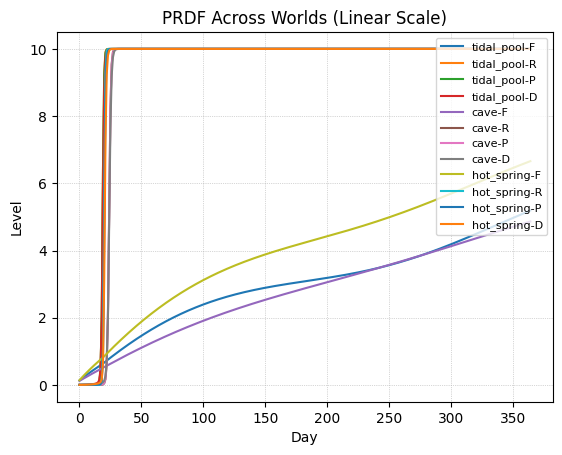

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load previously saved daily results
df = pd.read_csv("PRDF_three_worlds_daily.csv")

plt.figure()

for world in df["world"].unique():
    sub = df[df["world"] == world]
    plt.plot(sub["day"], sub["F"], label=f"{world}-F")
    plt.plot(sub["day"], sub["R"], label=f"{world}-R")
    plt.plot(sub["day"], sub["P"], label=f"{world}-P")
    plt.plot(sub["day"], sub["D"], label=f"{world}-D")

plt.xlabel("Day")
plt.ylabel("Level")
plt.title("PRDF Across Worlds (Linear Scale)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(loc="upper right", fontsize=8)
plt.show()

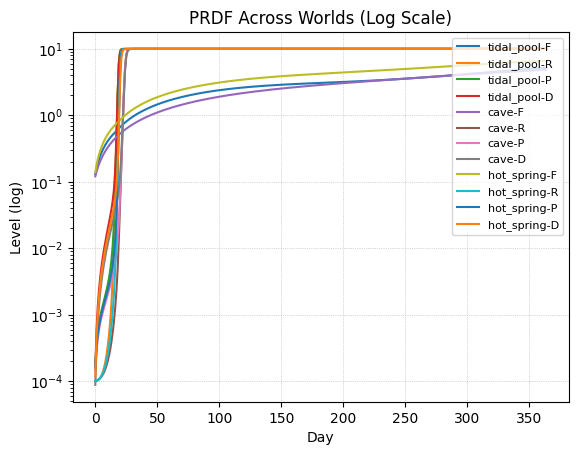

In [ ]:
plt.figure()

for world in df["world"].unique():
    sub = df[df["world"] == world]
    plt.plot(sub["day"], np.maximum(sub["F"], 1e-12), label=f"{world}-F")
    plt.plot(sub["day"], np.maximum(sub["R"], 1e-12), label=f"{world}-R")
    plt.plot(sub["day"], np.maximum(sub["P"], 1e-12), label=f"{world}-P")
    plt.plot(sub["day"], np.maximum(sub["D"], 1e-12), label=f"{world}-D")

plt.yscale("log")
plt.xlabel("Day")
plt.ylabel("Level (log)")
plt.title("PRDF Across Worlds (Log Scale)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(loc="upper right", fontsize=8)
plt.show()

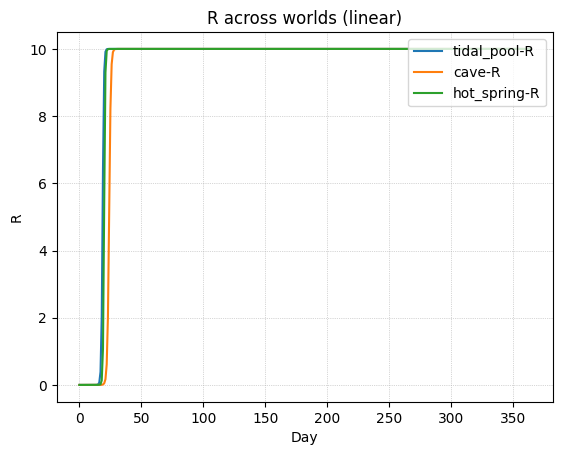

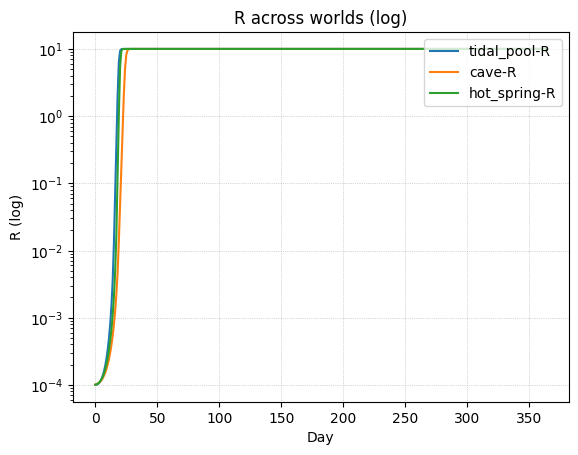

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("PRDF_three_worlds_daily.csv")

plt.figure()
for world in df["world"].unique():
    sub = df[df["world"] == world]
    plt.plot(sub["day"], sub["R"], label=f"{world}-R")
plt.xlabel("Day")
plt.ylabel("R")
plt.title("R across worlds (linear)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(loc="upper right")
plt.show()

plt.figure()
for world in df["world"].unique():
    sub = df[df["world"] == world]
    plt.plot(sub["day"], np.maximum(sub["R"], 1e-12), label=f"{world}-R")
plt.yscale("log")
plt.xlabel("Day")
plt.ylabel("R (log)")
plt.title("R across worlds (log)")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(loc="upper right")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_world_with_haven(
    world_name,
    days=365,
    steps_per_day=200,

    # World forcing
    seasonal_uv_amp=0.6,
    diurnal_uv_amp=1.0,
    seasonal_wet_amp=0.3,
    diurnal_wet_amp=0.2,
    refuge=1.0,

    temp_kinetics=1.0,
    temp_damage=1.0,

    # Couplings
    alpha_FR=1.2,
    alpha_RP=0.8,
    alpha_PD=0.6,

    # Haven parameter (NEW)
    haven_strength=0.5,   # 0=no haven, >0 increases shelter & concentration

    # Basal trickles
    sF=0.02, sR=1e-6, sP=1e-8, sD=1e-10,

    # Damage
    kF=0.01, kR=0.02, kP=0.015, kD=0.01,

    # Caps
    KF=5.0, KR=5.0, KP=5.0, KD=5.0,

    # Service allocation
    bind_strength=2.0,

    # Seeds
    F0=0.1, R0=1e-4, P0=1e-6, D0=1e-8,
):
    dt = 1.0 / steps_per_day

    F = float(F0)
    R = float(R0)
    P = float(P0)
    D = float(D0)

    out = []

    for day in range(days):
        for step in range(steps_per_day):

            wet = max(0.0,
                (1 + seasonal_uv_amp * np.sin(2*np.pi*day/365)) *
                (1 + diurnal_wet_amp * np.sin(2*np.pi*step/steps_per_day))
            )

            uv = max(0.0,
                (1 + seasonal_uv_amp * np.sin(2*np.pi*day/365)) *
                (1 + diurnal_uv_amp * np.sin(2*np.pi*step/steps_per_day))
            ) * refuge

            # Haven modifies chemistry
            concentration_boost = 1 + haven_strength * P
            shelter = max(0.0, 1 - haven_strength * P)

            kF_eff = kF * temp_damage * uv * shelter
            kR_eff = kR * temp_damage * uv * shelter
            kP_eff = kP * temp_damage * uv * shelter
            kD_eff = kD * temp_damage * uv * shelter

            formF = sF * temp_kinetics * wet * concentration_boost
            formR = sR * temp_kinetics * wet * concentration_boost
            formP = sP * temp_kinetics * wet * concentration_boost
            formD = sD * temp_kinetics * wet * concentration_boost

            dF = formF * (1 - F/KF) - kF_eff * F
            F = max(0.0, F + dF * dt)

            demand = bind_strength * (R + P + D)
            F_bound = min(F, demand)

            gR = formR + alpha_FR * F_bound * wet * R * (1 - R/KR)
            R = max(0.0, R + (gR - kR_eff * R) * dt)

            gP = formP + alpha_RP * R * wet * (1 - P/KP)
            P = max(0.0, P + (gP - kP_eff * P) * dt)

            gD = formD + alpha_PD * P * wet * (1 - D/KD)
            D = max(0.0, D + (gD - kD_eff * D) * dt)

        out.append({"world": world_name, "day": day, "F":F,"R":R,"P":P,"D":D})

    return pd.DataFrame(out)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_world_with_haven(
    world_name,
    days=365,
    steps_per_day=200,

    # World forcing
    seasonal_uv_amp=0.6,
    diurnal_uv_amp=1.0,
    seasonal_wet_amp=0.3,
    diurnal_wet_amp=0.2,
    refuge=1.0,

    temp_kinetics=1.0,
    temp_damage=1.0,

    # Couplings
    alpha_FR=1.2,
    alpha_RP=0.8,
    alpha_PD=0.6,

    # Haven parameter (NEW)
    haven_strength=0.5,   # 0=no haven, >0 increases shelter & concentration

    # Basal trickles
    sF=0.02, sR=1e-6, sP=1e-8, sD=1e-10,

    # Damage
    kF=0.01, kR=0.02, kP=0.015, kD=0.01,

    # Caps
    KF=5.0, KR=5.0, KP=5.0, KD=5.0,

    # Service allocation
    bind_strength=2.0,

    # Seeds
    F0=0.1, R0=1e-4, P0=1e-6, D0=1e-8,
):
    dt = 1.0 / steps_per_day

    F = float(F0)
    R = float(R0)
    P = float(P0)
    D = float(D0)

    out = []

    for day in range(days):
        for step in range(steps_per_day):

            wet = max(0.0,
                (1 + seasonal_uv_amp * np.sin(2*np.pi*day/365)) *
                (1 + diurnal_wet_amp * np.sin(2*np.pi*step/steps_per_day))
            )

            uv = max(0.0,
                (1 + seasonal_uv_amp * np.sin(2*np.pi*day/365)) *
                (1 + diurnal_uv_amp * np.sin(2*np.pi*step/steps_per_day))
            ) * refuge

            # Haven modifies chemistry
            concentration_boost = 1 + haven_strength * P
            shelter = max(0.0, 1 - haven_strength * P)

            kF_eff = kF * temp_damage * uv * shelter
            kR_eff = kR * temp_damage * uv * shelter
            kP_eff = kP * temp_damage * uv * shelter
            kD_eff = kD * temp_damage * uv * shelter

            formF = sF * temp_kinetics * wet * concentration_boost
            formR = sR * temp_kinetics * wet * concentration_boost
            formP = sP * temp_kinetics * wet * concentration_boost
            formD = sD * temp_kinetics * wet * concentration_boost

            dF = formF * (1 - F/KF) - kF_eff * F
            F = max(0.0, F + dF * dt)

            demand = bind_strength * (R + P + D)
            F_bound = min(F, demand)

            gR = formR + alpha_FR * F_bound * wet * R * (1 - R/KR)
            R = max(0.0, R + (gR - kR_eff * R) * dt)

            gP = formP + alpha_RP * R * wet * (1 - P/KP)
            P = max(0.0, P + (gP - kP_eff * P) * dt)

            gD = formD + alpha_PD * P * wet * (1 - D/KD)
            D = max(0.0, D + (gD - kD_eff * D) * dt)

        out.append({"world": world_name, "day": day, "F":F,"R":R,"P":P,"D":D})

    return pd.DataFrame(out)